# BINARY CLASSIFICATION PROBLEM:
## Does a given phrase contain a QoL indicator?

### Installation of required dependencies:

In [4]:
!pip install googletrans==4.0.0-rc1

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 13.5 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17397 sha256=d415b3e7ef144d87a3bec22bfdc6df3bdd489dc7d8d117954fd75e644d635d77
  Stored in directory: /home/ec2-user/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletra

In [8]:
# Install Spark NLP
!pip install spark-nlp==4.3.2 pyspark==3.3.1

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.2/473.2 kB 6.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 1.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845500 sha256=cc5667f77e5bc11836728f6fcbeefccf3d910a4cab963be9a5e1916dcd4f8220
  Stored in directory: /home/ec2-user/.cache/pip/wheels/0f/f0/3d/517368b8ce80486e84f89f214e0a022554e4ee64969f46279b
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.3.0
    Uninstalling pyspark-3.3.0:
      Successfully uninstalled pyspark-3.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker-pyspark 1.4.5 requires pyspark==3.3.0, but you have py

### Import required modules:

In [9]:
# Import modules
import os
import re
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.ml.linalg import *
from pyspark.sql.functions import expr
from pyspark.sql import functions as fun
from pyspark.sql import Row
from pyspark.ml import Pipeline
from pyspark.ml.feature import *
import sparknlp
from sparknlp import DocumentAssembler, Finisher
from sparknlp.annotator import *
from pyspark.ml.classification import *
from pyspark.ml.tuning import *
from pyspark.ml.evaluation import *
from sparknlp.annotator import WordEmbeddingsModel

### Load testimony data:

In [1]:
import pandas as pd
import boto3

# Crear una instancia de cliente de S3
s3 = boto3.client('s3')

# Especificar el nombre del archivo y el bucket
bucket_name = 'samtfm'
file_name = 'frases.csv'
file_name2 = 'frases_test.csv'

# Descargar el archivo desde S3 al directorio local
s3.download_file(bucket_name, file_name, file_name)
s3.download_file(bucket_name, file_name2, file_name2)

# Leer el archivo CSV en un dataframe
data = pd.read_csv(file_name)
unseen = pd.read_csv(file_name2)

#### Chack data is correctly loaded:

In [2]:
data.head()

,Enfermedad,Persona,frase,num_ind,indicador,dimension,contiene_indicador
0,Epilepsia,Primera Persona,Siempre me ha interesado cómo funciona el cere...,0,NaN,NaN,0
1,Epilepsia,Primera Persona,Me hice profesor de neurofisiología clínica y ...,0,NaN,NaN,0
2,Epilepsia,Primera Persona,"Después, tras sufrir un accidente de ciclismo ...",0,NaN,NaN,0
3,Epilepsia,Primera Persona,Fui operado por los hematomas subdurales que t...,0,NaN,NaN,0
4,Epilepsia,Primera Persona,"Tras estudiar la epilepsia durante décadas, me...",1,falta aceptación,Dimensión 8: Mental Health,1


In [3]:
unseen.head()

,Enfermedad,Persona,frase,num_ind,indicador,dimension,contiene_indicador
0,Cáncer,Primera Persona,no es algo que ni una madre ni una esposa y un...,1,fortaleza,Dimension 5: Vitality,1
1,Cáncer,Primera Persona,así a darle apoyo a uno a la otra persona para...,1,búsqueda apoyo social emocional,Dimension 6: Social Functioning,1
2,Cáncer,Primera Persona,y no caer,1,espíritu lucha,Dimension 5: Vitality,1
3,Cáncer,Primera Persona,porque es que el cáncer hoy en día es un una c...,1,esperanza,Dimension 5: Vitality,1
4,Cáncer,Primera Persona,adelante y tener una vida yo en los diez años ...,1,impacto ámbito laboral,Dimension 2: Role Limitations due to Physical ...,1


### Data pre-processing:

#### Translate testimonies into English:

In [6]:
from googletrans import Translator

# Función para traducir un texto de castellano a inglés
def translate_text(text):
    translator = Translator()
    translation = translator.translate(text, dest='en')
    return translation.text

# Aplicar la función a la columna 'frase' del DataFrame
for i, text in enumerate(data['frase']):
    translated_text = translate_text(text)
    data.loc[i, 'frase_traducida'] = translated_text
    print(f"Traduciendo observación {i+1}/{len(data)}")

print("Traducción completada.")

Traduciendo observación 1/910
Traduciendo observación 2/910
Traduciendo observación 3/910
Traduciendo observación 4/910
Traduciendo observación 5/910
Traduciendo observación 6/910
Traduciendo observación 7/910
Traduciendo observación 8/910
Traduciendo observación 9/910
Traduciendo observación 10/910
Traduciendo observación 11/910
Traduciendo observación 12/910
Traduciendo observación 13/910
Traduciendo observación 14/910
Traduciendo observación 15/910
Traduciendo observación 16/910
Traduciendo observación 17/910
Traduciendo observación 18/910
Traduciendo observación 19/910
Traduciendo observación 20/910
Traduciendo observación 21/910
Traduciendo observación 22/910
Traduciendo observación 23/910
Traduciendo observación 24/910
Traduciendo observación 25/910
Traduciendo observación 26/910
Traduciendo observación 27/910
Traduciendo observación 28/910
Traduciendo observación 29/910
Traduciendo observación 30/910
Traduciendo observación 31/910
Traduciendo observación 32/910
Traduciendo obser

Traduciendo observación 263/910
Traduciendo observación 264/910
Traduciendo observación 265/910
Traduciendo observación 266/910
Traduciendo observación 267/910
Traduciendo observación 268/910
Traduciendo observación 269/910
Traduciendo observación 270/910
Traduciendo observación 271/910
Traduciendo observación 272/910
Traduciendo observación 273/910
Traduciendo observación 274/910
Traduciendo observación 275/910
Traduciendo observación 276/910
Traduciendo observación 277/910
Traduciendo observación 278/910
Traduciendo observación 279/910
Traduciendo observación 280/910
Traduciendo observación 281/910
Traduciendo observación 282/910
Traduciendo observación 283/910
Traduciendo observación 284/910
Traduciendo observación 285/910
Traduciendo observación 286/910
Traduciendo observación 287/910
Traduciendo observación 288/910
Traduciendo observación 289/910
Traduciendo observación 290/910
Traduciendo observación 291/910
Traduciendo observación 292/910
Traduciendo observación 293/910
Traducie

Traduciendo observación 520/910
Traduciendo observación 521/910
Traduciendo observación 522/910
Traduciendo observación 523/910
Traduciendo observación 524/910
Traduciendo observación 525/910
Traduciendo observación 526/910
Traduciendo observación 527/910
Traduciendo observación 528/910
Traduciendo observación 529/910
Traduciendo observación 530/910
Traduciendo observación 531/910
Traduciendo observación 532/910
Traduciendo observación 533/910
Traduciendo observación 534/910
Traduciendo observación 535/910
Traduciendo observación 536/910
Traduciendo observación 537/910
Traduciendo observación 538/910
Traduciendo observación 539/910
Traduciendo observación 540/910
Traduciendo observación 541/910
Traduciendo observación 542/910
Traduciendo observación 543/910
Traduciendo observación 544/910
Traduciendo observación 545/910
Traduciendo observación 546/910
Traduciendo observación 547/910
Traduciendo observación 548/910
Traduciendo observación 549/910
Traduciendo observación 550/910
Traducie

Traduciendo observación 777/910
Traduciendo observación 778/910
Traduciendo observación 779/910
Traduciendo observación 780/910
Traduciendo observación 781/910
Traduciendo observación 782/910
Traduciendo observación 783/910
Traduciendo observación 784/910
Traduciendo observación 785/910
Traduciendo observación 786/910
Traduciendo observación 787/910
Traduciendo observación 788/910
Traduciendo observación 789/910
Traduciendo observación 790/910
Traduciendo observación 791/910
Traduciendo observación 792/910
Traduciendo observación 793/910
Traduciendo observación 794/910
Traduciendo observación 795/910
Traduciendo observación 796/910
Traduciendo observación 797/910
Traduciendo observación 798/910
Traduciendo observación 799/910
Traduciendo observación 800/910
Traduciendo observación 801/910
Traduciendo observación 802/910
Traduciendo observación 803/910
Traduciendo observación 804/910
Traduciendo observación 805/910
Traduciendo observación 806/910
Traduciendo observación 807/910
Traducie

In [7]:
from googletrans import Translator

# Función para traducir un texto de castellano a inglés
def translate_text(text):
    translator = Translator()
    translation = translator.translate(text, dest='en')
    return translation.text

# Aplicar la función a la columna 'frase' del DataFrame
for i, text in enumerate(unseen['frase']):
    translated_text = translate_text(text)
    unseen.loc[i, 'frase_traducida'] = translated_text
    print(f"Traduciendo observación {i+1}/{len(unseen)}")

print("Traducción completada.")

Traduciendo observación 1/104
Traduciendo observación 2/104
Traduciendo observación 3/104
Traduciendo observación 4/104
Traduciendo observación 5/104
Traduciendo observación 6/104
Traduciendo observación 7/104
Traduciendo observación 8/104
Traduciendo observación 9/104
Traduciendo observación 10/104
Traduciendo observación 11/104
Traduciendo observación 12/104
Traduciendo observación 13/104
Traduciendo observación 14/104
Traduciendo observación 15/104
Traduciendo observación 16/104
Traduciendo observación 17/104
Traduciendo observación 18/104
Traduciendo observación 19/104
Traduciendo observación 20/104
Traduciendo observación 21/104
Traduciendo observación 22/104
Traduciendo observación 23/104
Traduciendo observación 24/104
Traduciendo observación 25/104
Traduciendo observación 26/104
Traduciendo observación 27/104
Traduciendo observación 28/104
Traduciendo observación 29/104
Traduciendo observación 30/104
Traduciendo observación 31/104
Traduciendo observación 32/104
Traduciendo obser

#### (Aesthetic purposes)

In [10]:
# Wrap strings when printing
from IPython.display import HTML, display
def set_css():
  display(HTML('''
  
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [5]:
print("There is a {}% of positive observations in the dataset".format((sum(data.contiene_indicador)/len(data.contiene_indicador))*100))

Hay un 63.62637362637362% de observaciones positivas en el dataset


#### Keep only the desired varaiables:

In [11]:
data = data[["frase_traducida", "contiene_indicador"]]
unseen = unseen[["frase_traducida", "contiene_indicador"]]

In [12]:
data.head()

,frase_traducida,contiene_indicador
0,I have always been interested how the brain wo...,0
1,I became a professor of clinical neurophysiolo...,0
2,"Then, after suffering a cycling accident at ag...",0
3,I was operated by the subdural bruises that I ...,0
4,"After studying epilepsy for decades, I found i...",1


#### Start the SaprNLP session:

In [13]:
# Start the Spark NLP session
spark = sparknlp.start()

:: loading settings :: url = jar:file:/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ec2-user/.ivy2/cache
The jars for the packages stored in: /home/ec2-user/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-727b18e0-1c9a-434e-ac96-cbaa5c31247a;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;4.3.2 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.16.0 in central
	found com.google.guava#guava;31.1-jre in central
	found com.google.guava#fa

downloading https://repo1.maven.org/maven2/com/google/api/gax-httpjson/0.105.1/gax-httpjson-0.105.1.jar ...
	[SUCCESSFUL ] com.google.api#gax-httpjson;0.105.1!gax-httpjson.jar (22ms)
downloading https://repo1.maven.org/maven2/com/google/cloud/google-cloud-core-grpc/2.9.0/google-cloud-core-grpc-2.9.0.jar ...
	[SUCCESSFUL ] com.google.cloud#google-cloud-core-grpc;2.9.0!google-cloud-core-grpc.jar (5ms)
downloading https://repo1.maven.org/maven2/io/grpc/grpc-core/1.51.0/grpc-core-1.51.0.jar ...
	[SUCCESSFUL ] io.grpc#grpc-core;1.51.0!grpc-core.jar (12ms)
downloading https://repo1.maven.org/maven2/com/google/api/gax/2.20.1/gax-2.20.1.jar ...
	[SUCCESSFUL ] com.google.api#gax;2.20.1!gax.jar (9ms)
downloading https://repo1.maven.org/maven2/com/google/api/gax-grpc/2.20.1/gax-grpc-2.20.1.jar ...
	[SUCCESSFUL ] com.google.api#gax-grpc;2.20.1!gax-grpc.jar (10ms)
downloading https://repo1.maven.org/maven2/io/grpc/grpc-alts/1.51.0/grpc-alts-1.51.0.jar ...
	[SUCCESSFUL ] io.grpc#grpc-alts;1.51.0!grp

	com.google.api#gax-httpjson;0.105.1 from central in [default]
	com.google.api-client#google-api-client;2.1.1 from central in [default]
	com.google.api.grpc#gapic-google-cloud-storage-v2;2.16.0-alpha from central in [default]
	com.google.api.grpc#grpc-google-cloud-storage-v2;2.16.0-alpha from central in [default]
	com.google.api.grpc#grpc-google-iam-v1;1.6.22 from central in [default]
	com.google.api.grpc#proto-google-cloud-storage-v2;2.16.0-alpha from central in [default]
	com.google.api.grpc#proto-google-common-protos;2.11.0 from central in [default]
	com.google.api.grpc#proto-google-iam-v1;1.6.22 from central in [default]
	com.google.apis#google-api-services-storage;v1-rev20220705-2.0.0 from central in [default]
	com.google.auth#google-auth-library-credentials;1.13.0 from central in [default]
	com.google.auth#google-auth-library-oauth2-http;1.13.0 from central in [default]
	com.google.auto.value#auto-value-annotations;1.10.1 from central in [default]
	com.google.cloud#google-cloud-c

23/07/08 09:18:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


#### Transform the pandas dataframes into spark dataframes:

In [14]:
# Manually define schema
schema = StructType([
    StructField("frase_traducida", StringType(), nullable=True),
    StructField("contiene_indicador", StringType(), nullable=True)
])

rdd_data = spark.sparkContext.parallelize(data.values.tolist())

# Create the Spark DataFrame from the RDD and the schema
frases = spark.createDataFrame(rdd_data, schema)

# Verify it's been created correctly
frases.show()


+--------------------+------------------+
|     frase_traducida|contiene_indicador|
+--------------------+------------------+
|I have always bee...|                 0|
|I became a profes...|                 0|
|Then, after suffe...|                 0|
|I was operated by...|                 0|
|After studying ep...|                 1|
|that now I was a ...|                 1|
|I have evolved to...|                 1|
|I have evolved to...|                 1|
|I have evolved to...|                 1|
|of epilepsy to pe...|                 0|
|I share my experi...|                 1|
|, And promote the...|                 1|
|I self -explore i...|                 1|
|For me my mind wa...|                 1|
|For me my mind wa...|                 1|
|that is, a separa...|                 1|
|that is to say th...|                 1|
|And starting to o...|                 1|
|This help is not ...|                 1|
|And you know that...|                 1|
+--------------------+------------

In [15]:
# Manually define schema
schema = StructType([
    StructField("frase_traducida", StringType(), nullable=True),
    StructField("contiene_indicador", StringType(), nullable=True)
])

rdd_data = spark.sparkContext.parallelize(unseen.values.tolist())

# Create the Spark DataFrame from the RDD and the schema
unseen = spark.createDataFrame(rdd_data, schema)

# Verify it's been created correctly
unseen.show()

+--------------------+------------------+
|     frase_traducida|contiene_indicador|
+--------------------+------------------+
|It is not somethi...|                 1|
|thus to support o...|                 1|
|        And not fall|                 1|
|Because cancer to...|                 1|
|go ahead and have...|                 1|
|Because here I ha...|                 1|
|That is why I nev...|                 1|
|And the next day ...|                 1|
|“Hello, my name i...|                 0|
|10 years ago I wa...|                 1|
|Due to the tumor ...|                 0|
|I already recover...|                 1|
|In December last ...|                 1|
|, but this time t...|                 1|
|I am currently in...|                 0|
|The recovery is s...|                 1|
|, and surely with...|                 1|
|, and surely with...|                 1|
|I want to thank n...|                 1|
|, and to all the ...|                 1|
+--------------------+------------

#### Dividing input data into train and test sets:

In [16]:
train, test = frases.randomSplit([0.8, 0.2], seed = 123)

## Bag of Words:

In [19]:
# First we define the modules that will compose the NLP pipeline, 
# next we create a function to train different models with different
# hyperparameter combinations while saving the results in a dataframe

# Define the assembler
assembler = DocumentAssembler()\
  .setInputCol('frase_traducida')\
  .setOutputCol('document')
docs = assembler.transform(frases)
docs.limit(5).toPandas()

# Define the word tokenizer
tokenizer = Tokenizer()\
  .setInputCols(['document'])\
  .setOutputCol('tokens')

# Define the lemmetizer
lemmatizer = LemmatizerModel.pretrained()\
  .setInputCols(['tokens'])\
  .setOutputCol('lemma')

# Define the normalizer
normalizer = Normalizer()\
  .setInputCols(['lemma'])\
  .setOutputCol('normalized')\
  .setLowercase(True)

# Define the finisher
finisher = Finisher()\
  .setInputCols(['normalized'])\
  .setOutputCols(['normalized'])\
  .setOutputAsArray(True)

# Define the stop words
stopwords = set(StopWordsRemover.loadDefaultStopWords('english'))

# Define the stopword remover
sw_remover = StopWordsRemover()\
  .setInputCol('normalized')\
  .setOutputCol('filtered')\
  .setStopWords(list(stopwords))

count_vectorizer = CountVectorizer(
  inputCol='filtered',
  outputCol='features'
)


# Define the pipeline
text_processing_pipeline = Pipeline(
  stages = [
    assembler,
    tokenizer,
    lemmatizer,
    normalizer,
    finisher,
    sw_remover,
    count_vectorizer
   ])

# Define a function to convert labels to indices and use it to fit the data
label_indexer = StringIndexer(
  inputCol = 'contiene_indicador', 
  outputCol = 'label').fit(frases)

# Define a function to convert predicted indices to labels
prediction_deindexer = IndexToString(
  inputCol = 'prediction', 
  outputCol = 'pred_label', 
  labels = label_indexer.labels)


results = []

def fit_model(model):
    # Construct the overall pipeline
    pipeline = Pipeline(
        stages=[
            text_processing_pipeline,
            label_indexer,
            model,
            prediction_deindexer
        ]
    )

    # Train the model
    model = pipeline.fit(train)

    # Make predictions on the train and test sets
    train_predicted = model.transform(train)
    test_predicted = model.transform(test)

    # Initialize the evaluators
    evaluator_precision = MulticlassClassificationEvaluator(metricName='weightedPrecision')
    evaluator_recall = MulticlassClassificationEvaluator(metricName='weightedRecall')
    evaluator_f1 = MulticlassClassificationEvaluator(metricName='f1')

    # Calculate precision, recall, and F1 score on the train set
    train_precision = evaluator_precision.evaluate(train_predicted)
    train_recall = evaluator_recall.evaluate(train_predicted)
    train_f1 = evaluator_f1.evaluate(train_predicted)

    # Calculate precision, recall, and F1 score on the test set
    test_precision = evaluator_precision.evaluate(test_predicted)
    test_recall = evaluator_recall.evaluate(test_predicted)
    test_f1 = evaluator_f1.evaluate(test_predicted)

    # Create a dictionary with the results
    result = {
        'Train Precision': train_precision,
        'Train Recall': train_recall,
        'Train F1 Score': train_f1,
        'Test Precision': test_precision,
        'Test Recall': test_recall,
        'Test F1 Score': test_f1
    }

    return pd.DataFrame(result, index=[0])

import itertools

# Define the common options for featuresCol and labelCol
common_options = {
    'featuresCol': 'features',
    'labelCol': 'label'
}

# Define the hyperparameter options for each model
hyperparameter_options = {
    'NaiveBayes': {
        'smoothing': [0.5, 1.0, 1.5]
    },
    'LogisticRegression': {
        'maxIter': [50, 100, 200],
        'regParam': [0.0, 0.1, 0.2]
    },
    'LinearSVC': {
        'maxIter': [50, 100, 200],
        'regParam': [0.0, 0.1, 0.2]
    },
    'RandomForestClassifier': {
        'numTrees': [10, 20, 30],
        'maxDepth': [3, 5, 7]
    },
    'GBTClassifier': {
        'maxIter': [10, 20, 30],
        'maxDepth': [3, 5, 7],
        'stepSize': [0.1, 0.2, 0.3]
    }
}

# Generate all combinations of hyperparameters for each model
model_list = []
for model_name, options in hyperparameter_options.items():
    for params in itertools.product(*options.values()):
        model_params = dict(list(common_options.items()) + list(zip(options.keys(), params)))
        model = eval(f"{model_name}(**model_params)")
        model_list.append(model)

# Create a list of dictionaries with model names and parameters
results = []
for model_name, options in hyperparameter_options.items():
    for params in itertools.product(*options.values()):
        model_params = dict(list(common_options.items()) + list(zip(options.keys(), params)))
        result = {
            'Model_name': model_name,
            'Parameters': model_params
        }
        results.append(result)

# Create the results DataFrame
bow_results = pd.concat([pd.DataFrame(model_list, columns=["Model"]), pd.DataFrame(results)], axis=1)

bow_results.head()

# Merge with the combinatios to form the desired output dataframe
metrics = pd.DataFrame()
for model in bow_results.Model:
    metrics = pd.concat([metrics, fit_model(model)], axis = 0)
    
bow_results = pd.concat([bow_results, metrics.reset_index(drop = True)], axis = 1, ignore_index=True)
new_column_names = {0: 'Model', 1: 'Model_name', 2: 'params', 3:'train_acc', 4:'train_rec', 5:'train_f1', 6:'test_acc', 7:'test_rec', 8:'test_f1'}
bow_results.rename(columns=new_column_names, inplace=True)

bow_results.head()

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
23/07/02 21:33:19 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 


,Model,Model_name,params,train_acc,train_rec,train_f1,test_acc,test_rec,test_f1
0,NaiveBayes_36f489cb7e77,NaiveBayes,"{'featuresCol': 'features', 'labelCol': 'label...",0.933823,0.932969,0.932176,0.620042,0.636872,0.621070
1,NaiveBayes_9933c180f4cf,NaiveBayes,"{'featuresCol': 'features', 'labelCol': 'label...",0.919216,0.916553,0.914897,0.629000,0.648045,0.622569
2,NaiveBayes_b2ac2b53e361,NaiveBayes,"{'featuresCol': 'features', 'labelCol': 'label...",0.910217,0.904241,0.901403,0.635364,0.653631,0.620947
3,LogisticRegression_ea7859ae3a78,LogisticRegression,"{'featuresCol': 'features', 'labelCol': 'label...",0.993233,0.993160,0.993146,0.654482,0.659218,0.656334
4,LogisticRegression_bf6c0993cb58,LogisticRegression,"{'featuresCol': 'features', 'labelCol': 'label...",0.978837,0.978112,0.977954,0.627995,0.648045,0.616474


In [21]:
# Convert the DataFrame to CSV format in memory.
csv_buffer = bow_results.to_csv(index=False).encode()

# Create an instance of the S3 client
s3_client = boto3.client('s3')

# Sepcify file name and route in the S3
bucket_name = 'samtfm'
file_name = 'bow_results_S3.csv'

# Uppload file to the S3 bucket
s3_client.put_object(Body=csv_buffer, Bucket=bucket_name, Key=file_name)

{'ResponseMetadata': {'RequestId': '94XGM6J8C31PE61P',
  'HostId': 'KwUsVPY68J8I+14STVMrJ2NL7uv/1xhj1O1mfBAstGFAqVMk8hTAZ4K3EyxTzzRc88eFF7Ijdg4=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'KwUsVPY68J8I+14STVMrJ2NL7uv/1xhj1O1mfBAstGFAqVMk8hTAZ4K3EyxTzzRc88eFF7Ijdg4=',
   'x-amz-request-id': '94XGM6J8C31PE61P',
   'date': 'Sun, 02 Jul 2023 21:39:46 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"1bdfd64fc6f9b440b9651ebec0a72df8"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"1bdfd64fc6f9b440b9651ebec0a72df8"',
 'ServerSideEncryption': 'AES256'}

# TF-IDF:

In [15]:
# First we define the modules that will compose the NLP pipeline, 
# next we create a function to train different models with different
# hyperparameter combinations while saving the results in a dataframe

# Define the assembler
assembler = DocumentAssembler()\
  .setInputCol('frase_traducida')\
  .setOutputCol('document')
docs = assembler.transform(frases)
docs.limit(5).toPandas()

# Define the word tokenizer
tokenizer = Tokenizer()\
  .setInputCols(['document'])\
  .setOutputCol('tokens')

# Define the lemmetizer
lemmatizer = LemmatizerModel.pretrained()\
  .setInputCols(['tokens'])\
  .setOutputCol('lemma')

# Define the normalizer
normalizer = Normalizer()\
  .setInputCols(['lemma'])\
  .setOutputCol('normalized')\
  .setLowercase(True)

# Define the finisher
finisher = Finisher()\
  .setInputCols(['normalized'])\
  .setOutputCols(['normalized'])\
  .setOutputAsArray(True)

# Define the stop words
stopwords = set(StopWordsRemover.loadDefaultStopWords('english'))

# Define the stopword remover
sw_remover = StopWordsRemover()\
  .setInputCol('normalized')\
  .setOutputCol('filtered')\
  .setStopWords(list(stopwords))

# Define count vectorizer
count_vectorizer = CountVectorizer(
  inputCol = 'filtered',
  outputCol = 'tf'
  )

# Define TF-IDF
tfidf = IDF(
  inputCol = 'tf',
  outputCol = 'tfidf'
  )

# Define the pipeline
text_processing_pipeline = Pipeline(
  stages = [
    assembler,
    tokenizer,
    lemmatizer,
    normalizer,
    finisher,
    sw_remover,
    count_vectorizer,
    tfidf
   ])

# Define a function to convert labels to indices and use it to fit the data
label_indexer = StringIndexer(
  inputCol = 'contiene_indicador', 
  outputCol = 'label').fit(frases)

# Define a function to convert predicted indices to labels
prediction_deindexer = IndexToString(
  inputCol = 'prediction', 
  outputCol = 'pred_label', 
  labels = label_indexer.labels)


results = []

def fit_model(model):
    # Construct the overall pipeline
    pipeline = Pipeline(
        stages=[
            text_processing_pipeline,
            label_indexer,
            model,
            prediction_deindexer
        ]
    )

    # Train the model
    model = pipeline.fit(train)

    # Make predictions on the train and test sets
    train_predicted = model.transform(train)
    test_predicted = model.transform(test)

    # Initialize the evaluators
    evaluator_precision = MulticlassClassificationEvaluator(metricName='weightedPrecision')
    evaluator_recall = MulticlassClassificationEvaluator(metricName='weightedRecall')
    evaluator_f1 = MulticlassClassificationEvaluator(metricName='f1')

    # Calculate precision, recall, and F1 score on the train set
    train_precision = evaluator_precision.evaluate(train_predicted)
    train_recall = evaluator_recall.evaluate(train_predicted)
    train_f1 = evaluator_f1.evaluate(train_predicted)

    # Calculate precision, recall, and F1 score on the test set
    test_precision = evaluator_precision.evaluate(test_predicted)
    test_recall = evaluator_recall.evaluate(test_predicted)
    test_f1 = evaluator_f1.evaluate(test_predicted)

    # Create a dictionary with the results
    result = {
        'Train Precision': train_precision,
        'Train Recall': train_recall,
        'Train F1 Score': train_f1,
        'Test Precision': test_precision,
        'Test Recall': test_recall,
        'Test F1 Score': test_f1
    }

    return pd.DataFrame(result, index=[0])

import itertools

# Define the common options for featuresCol and labelCol
common_options = {
    'featuresCol': 'tfidf',
    'labelCol': 'label'
}

# Define the hyperparameter options for each model
hyperparameter_options = {
    'NaiveBayes': {
        'smoothing': [0.5, 1.0, 1.5]
    },
    'LogisticRegression': {
        'maxIter': [50, 100, 200],
        'regParam': [0.0, 0.1, 0.2]
    },
    'LinearSVC': {
        'maxIter': [50, 100, 200],
        'regParam': [0.0, 0.1, 0.2]
    },
    'RandomForestClassifier': {
        'numTrees': [10, 20, 30],
        'maxDepth': [3, 5, 7]
    },
    'GBTClassifier': {
        'maxIter': [10, 20, 30],
        'maxDepth': [3, 5, 7],
        'stepSize': [0.1, 0.2, 0.3]
    }
}

# Generate all combinations of hyperparameters for each model
model_list = []
for model_name, options in hyperparameter_options.items():
    for params in itertools.product(*options.values()):
        model_params = dict(list(common_options.items()) + list(zip(options.keys(), params)))
        model = eval(f"{model_name}(**model_params)")
        model_list.append(model)

# Create a list of dictionaries with model names and parameters
results = []
for model_name, options in hyperparameter_options.items():
    for params in itertools.product(*options.values()):
        model_params = dict(list(common_options.items()) + list(zip(options.keys(), params)))
        result = {
            'Model_name': model_name,
            'Parameters': model_params
        }
        results.append(result)

# Create the results DataFrame
tfidf_results = pd.concat([pd.DataFrame(model_list, columns = ["Model"]), pd.DataFrame(results)], axis = 1)

tfidf_results.head()

# Merge with the combinatios to form the desired output dataframe
metrics = pd.DataFrame()
for model in tfidf_results.Model:
    metrics = pd.concat([metrics, fit_model(model)], axis = 0)
    
tfidf_results = pd.concat([tfidf_results, metrics.reset_index(drop = True)], axis = 1, ignore_index=True)
new_column_names = {0: 'Model', 1: 'Model_name', 2: 'params', 3:'train_acc', 4:'train_rec', 5:'train_f1', 6:'test_acc', 7:'test_rec', 8:'test_f1'}
tfidf_results.rename(columns=new_column_names, inplace=True)

tfidf_results.head()

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ | ]lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
Download done! Loading the resource.
[ / ]

[OK!]


23/07/02 21:06:04 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/07/02 21:06:04 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/07/02 21:06:04 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/07/02 21:06:04 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


,Model,Model_name,params,train_acc,train_rec,train_f1,test_acc,test_rec,test_f1
0,NaiveBayes_26dc767f2ae1,NaiveBayes,"{'featuresCol': 'tfidf', 'labelCol': 'label', ...",0.942544,0.942544,0.942544,0.616268,0.608939,0.611937
1,NaiveBayes_35f4a3499532,NaiveBayes,"{'featuresCol': 'tfidf', 'labelCol': 'label', ...",0.942544,0.942544,0.942544,0.613756,0.608939,0.611051
2,NaiveBayes_b8e962b8748f,NaiveBayes,"{'featuresCol': 'tfidf', 'labelCol': 'label', ...",0.943870,0.943912,0.943889,0.606983,0.603352,0.605003
3,LogisticRegression_7136759f226b,LogisticRegression,"{'featuresCol': 'tfidf', 'labelCol': 'label', ...",0.993233,0.993160,0.993146,0.654482,0.659218,0.656334
4,LogisticRegression_c6850738d187,LogisticRegression,"{'featuresCol': 'tfidf', 'labelCol': 'label', ...",0.978837,0.978112,0.977954,0.627995,0.648045,0.616474


In [18]:
# Convert the DataFrame to CSV format in memory.
csv_buffer = tfidf_results.to_csv(index=False).encode()

# Create an instance of the S3 client
s3_client = boto3.client('s3')

# Sepcify file name and route in the S3
bucket_name = 'samtfm'
file_name = 'tfidf_results_S3.csv'

# Uppload file to the S3 bucket
s3_client.put_object(Body=csv_buffer, Bucket=bucket_name, Key=file_name)

{'ResponseMetadata': {'RequestId': '3FEJ8HED3V7TTCMF',
  'HostId': '8mbDYaHIiExXEqxCmJEVmD6anUd8pPHvER0irq+fkBOH/XmE50VlkbxzRFHwDdppSaYnSkZpvt4=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '8mbDYaHIiExXEqxCmJEVmD6anUd8pPHvER0irq+fkBOH/XmE50VlkbxzRFHwDdppSaYnSkZpvt4=',
   'x-amz-request-id': '3FEJ8HED3V7TTCMF',
   'date': 'Sun, 02 Jul 2023 21:19:19 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"9e57c9903a25621a2c8bc7767bbcdb99"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"9e57c9903a25621a2c8bc7767bbcdb99"',
 'ServerSideEncryption': 'AES256'}

# DEEP LEARNING APPROACH

## GloVe

In [ ]:
# First we define the modules that will compose the NLP pipeline, 
# next we create a function to train different models with different
# hyperparameter combinations while saving the results in a dataframe

from pyspark.ml.feature import SQLTransformer

# Define the assembler
document_assembler = DocumentAssembler().setInputCol('frase_traducida').setOutputCol('document')

# Define the word tokenizer
tokenizer = Tokenizer().setInputCols(['document']).setOutputCol('token')

# Define the stopword remover
stops = StopWordsCleaner.pretrained()\
.setInputCols("token")\
.setOutputCol("cleanedToken")

# Create the sentence embeddings feature extractor
sentence_embeddings = SentenceEmbeddings() \
  .setInputCols(["document", "embeddings"]) \
  .setOutputCol("sentence_embeddings") \
  .setPoolingStrategy("AVERAGE")

# Define a function to convert labels to indices and use it to fit the data
label_indexer = StringIndexer(
  inputCol = 'contiene_indicador', 
  outputCol = 'label').fit(frases)

def fit_model(epochs):
    
    # Create the feature extractor using GloVe word embeddings
    embeddings = WordEmbeddingsModel.pretrained("glove_100d", "en") \
      .setInputCols(["document", "cleanedToken"]) \
      .setOutputCol("embeddings")
    
    # Create the text classifier using ClassifierDLApproach.
    classifier_dl = ClassifierDLApproach() \
      .setInputCols(['sentence_embeddings']) \
      .setOutputCol('prediction') \
      .setLabelColumn('label') \
      .setBatchSize(comb["batchSize"]) \
      .setMaxEpochs(comb["maxEpochs"]) \
      .setLr(comb["lr"]) \
      .setDropout(comb["dropout"]) \
      .setEnableOutputLogs(True)


    # Creating the pipeline
    pipeline = Pipeline(stages=[
      document_assembler,
      tokenizer,
      stops,
      embeddings,
      sentence_embeddings,
      label_indexer,
      classifier_dl
    ])
    
    # Train the model
    model_pipeline = pipeline.fit(train)

    # Make predictions on the train and test sets
    train_predicted = model_pipeline.transform(train).selectExpr("label", "double(prediction.result[0]) as prediction")
    test_predicted = model_pipeline.transform(test).selectExpr("label", "double(prediction.result[0]) as prediction")

    # Initialize the evaluators
    evaluator_precision = MulticlassClassificationEvaluator(metricName='weightedPrecision')
    evaluator_recall = MulticlassClassificationEvaluator(metricName='weightedRecall')
    evaluator_f1 = MulticlassClassificationEvaluator(metricName='f1')

    # Calculate precision, recall, and F1 score on the train set
    train_precision = evaluator_precision.evaluate(train_predicted)
    train_recall = evaluator_recall.evaluate(train_predicted)
    train_f1 = evaluator_f1.evaluate(train_predicted)

    # Calculate precision, recall, and F1 score on the test set
    test_precision = evaluator_precision.evaluate(test_predicted)
    test_recall = evaluator_recall.evaluate(test_predicted)
    test_f1 = evaluator_f1.evaluate(test_predicted)

    # Create a dictionary with the results
    result = {
        'Train Precision': train_precision,
        'Train Recall': train_recall,
        'Train F1 Score': train_f1,
        'Test Precision': test_precision,
        'Test Recall': test_recall,
        'Test F1 Score': test_f1
    }

    return pd.DataFrame(result, index=[0])

# Define the hyperparameter options for each model
hyperparameter_options = {
    'glove_100d': {
            'batchSize': [32, 64],
            'dropout': [0, 0.2, 0.4],
            'lr': [0.001, 0.01, 0.1],
            'maxEpochs': [20]
    }
}

# Create the results DataFrame combining the metrics and parameter combinations
combinations = []
for key, options in hyperparameter_options.items():
    keys = options.keys()
    values = options.values()
    param_combinations = [dict(zip(keys, param_values)) for param_values in itertools.product(*values)]
    for combination in param_combinations:
        combination['model'] = key
        combinations.append(combination)

dla_results = pd.DataFrame()
for comb in combinations:
    dla_results = pd.concat([dla_results.reset_index(drop = True), fit_model(comb)], axis = 0)
    
dla_results = pd.concat([dla_results.reset_index(drop = True), pd.DataFrame(combinations).reset_index(drop = True)], axis = 1, ignore_index=True)

new_column_names = {0:'train_acc', 1:'train_rec', 2:'train_f1', 3:'test_acc', 4:'test_rec', 5:'test_f1', 6:'batch_size', 7:'dropout', 8:'lr', 9:'epochs'}
dla_results.rename(columns=new_column_names, inplace=True)

dla_results.head()

In [13]:
glove_results = dla_results
glove_results.sort_values(by = ["test_f1"], ascending = False).head()

,train_acc,train_rec,train_f1,test_acc,test_rec,test_f1,batch_size,dropout,lr,epochs,10
0,0.937948,0.935705,0.934658,0.846281,0.843575,0.839051,32,0.0,0.001,20,bert_embeddings_bert_large_uncased_whole_word_...
1,0.408130,0.638851,0.498069,0.391498,0.625698,0.481637,32,0.0,0.010,20,bert_embeddings_bert_large_uncased_whole_word_...
2,0.408130,0.638851,0.498069,0.391498,0.625698,0.481637,32,0.0,0.100,20,bert_embeddings_bert_large_uncased_whole_word_...
3,0.942711,0.942544,0.942131,0.865922,0.865922,0.865922,32,0.2,0.001,20,bert_embeddings_bert_large_uncased_whole_word_...
4,0.408130,0.638851,0.498069,0.391498,0.625698,0.481637,32,0.2,0.010,20,bert_embeddings_bert_large_uncased_whole_word_...
5,0.408130,0.638851,0.498069,0.391498,0.625698,0.481637,32,0.2,0.100,20,bert_embeddings_bert_large_uncased_whole_word_...
6,0.924988,0.924761,0.924030,0.877095,0.877095,0.877095,32,0.4,0.001,20,bert_embeddings_bert_large_uncased_whole_word_...
7,0.408130,0.638851,0.498069,0.391498,0.625698,0.481637,32,0.4,0.010,20,bert_embeddings_bert_large_uncased_whole_word_...
8,0.408130,0.638851,0.498069,0.391498,0.625698,0.481637,32,0.4,0.100,20,bert_embeddings_bert_large_uncased_whole_word_...
9,0.968541,0.968536,0.968442,0.894223,0.893855,0.894010,64,0.0,0.001,20,bert_embeddings_bert_large_uncased_whole_word_...


In [14]:
# Convert the DataFrame to CSV format in memory.
csv_buffer = glove_results.to_csv(index=False).encode()

# Create an instance of the S3 client
s3_client = boto3.client('s3')

# Sepcify file name and route in the S3
bucket_name = 'samtfm'
file_name = 'binary_glove_results_balanced_S3_total.csv'

# Uppload file to the S3 bucket
s3_client.put_object(Body=csv_buffer, Bucket=bucket_name, Key=file_name)

{'ResponseMetadata': {'RequestId': 'W5K4692K475D74XN',
  'HostId': 'WLAuxSSgE2pOHanSUprNbLdnm6Ng54/CV1QsT3fdvpVCOy+Hg14gzcf5X6clGPz8vZSQYJ85Agw=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'WLAuxSSgE2pOHanSUprNbLdnm6Ng54/CV1QsT3fdvpVCOy+Hg14gzcf5X6clGPz8vZSQYJ85Agw=',
   'x-amz-request-id': 'W5K4692K475D74XN',
   'date': 'Mon, 03 Jul 2023 21:05:00 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"eca39077cd0f96bbe0486a3da11e29a4"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"eca39077cd0f96bbe0486a3da11e29a4"',
 'ServerSideEncryption': 'AES256'}

## BERT

In [17]:
# First we define the modules that will compose the NLP pipeline, 
# next we create a function to train different models with different
# hyperparameter combinations while saving the results in a dataframe

from pyspark.ml.feature import SQLTransformer

# Define the assembler
document_assembler = DocumentAssembler().setInputCol('frase_traducida').setOutputCol('document')

# Define the word tokenizer
tokenizer = Tokenizer().setInputCols(['document']).setOutputCol('token')

# Define the stopword remover
stops = StopWordsCleaner.pretrained()\
.setInputCols("token")\
.setOutputCol("cleanedToken")

# Create the sentence embeddings feature extractor
sentence_embeddings = SentenceEmbeddings() \
  .setInputCols(["document", "embeddings"]) \
  .setOutputCol("sentence_embeddings") \
  .setPoolingStrategy("AVERAGE")

# Define a function to convert labels to indices and use it to fit the data
label_indexer = StringIndexer(
  inputCol = 'contiene_indicador', 
  outputCol = 'label').fit(frases)

def fit_model(epochs):
    
    # Create the feature extractor using BERT word embeddings
    embeddings = BertEmbeddings.pretrained("bert_embeddings_bert_large_uncased_whole_word_masking", "en") \
      .setInputCols(["document", "cleanedToken"]) \
      .setOutputCol("embeddings")
    
    # Create the text classifier using ClassifierDLApproach.
    classifier_dl = ClassifierDLApproach() \
      .setInputCols(['sentence_embeddings']) \
      .setOutputCol('prediction') \
      .setLabelColumn('label') \
      .setBatchSize(comb["batchSize"]) \
      .setMaxEpochs(comb["maxEpochs"]) \
      .setLr(comb["lr"]) \
      .setDropout(comb["dropout"]) \
      .setEnableOutputLogs(True)


    # Creating the pipeline
    pipeline = Pipeline(stages=[
      document_assembler,
      tokenizer,
      stops,
      embeddings,
      sentence_embeddings,
      label_indexer,
      classifier_dl
    ])
    
    # Train the model
    model_pipeline = pipeline.fit(train)

    # Make predictions on the train and test sets
    train_predicted = model_pipeline.transform(train).selectExpr("label", "double(prediction.result[0]) as prediction")
    test_predicted = model_pipeline.transform(test).selectExpr("label", "double(prediction.result[0]) as prediction")

    # Initialize the evaluators
    evaluator_precision = MulticlassClassificationEvaluator(metricName='weightedPrecision')
    evaluator_recall = MulticlassClassificationEvaluator(metricName='weightedRecall')
    evaluator_f1 = MulticlassClassificationEvaluator(metricName='f1')

    # Calculate precision, recall, and F1 score on the train set
    train_precision = evaluator_precision.evaluate(train_predicted)
    train_recall = evaluator_recall.evaluate(train_predicted)
    train_f1 = evaluator_f1.evaluate(train_predicted)

    # Calculate precision, recall, and F1 score on the test set
    test_precision = evaluator_precision.evaluate(test_predicted)
    test_recall = evaluator_recall.evaluate(test_predicted)
    test_f1 = evaluator_f1.evaluate(test_predicted)

    # Create a dictionary with the results
    result = {
        'Train Precision': train_precision,
        'Train Recall': train_recall,
        'Train F1 Score': train_f1,
        'Test Precision': test_precision,
        'Test Recall': test_recall,
        'Test F1 Score': test_f1
    }

    return pd.DataFrame(result, index=[0])

# Define the hyperparameter options for each model
hyperparameter_options = {
    'bert_embeddings_bert_large_uncased_whole_word_masking': {
            'batchSize': [32, 64],
            'dropout': [0, 0.2, 0.4],
            'lr': [0.001, 0.01, 0.1],
            'maxEpochs': [20]
    }
}

# Create the results DataFrame combining the metrics and parameter combinations
combinations = []
for key, options in hyperparameter_options.items():
    keys = options.keys()
    values = options.values()
    param_combinations = [dict(zip(keys, param_values)) for param_values in itertools.product(*values)]
    for combination in param_combinations:
        combination['model'] = key
        combinations.append(combination)

dla_results = pd.DataFrame()
for comb in combinations:
    dla_results = pd.concat([dla_results.reset_index(drop = True), fit_model(comb)], axis = 0)
    
dla_results = pd.concat([dla_results.reset_index(drop = True), pd.DataFrame(combinations).reset_index(drop = True)], axis = 1, ignore_index=True)

new_column_names = {0:'train_acc', 1:'train_rec', 2:'train_f1', 3:'test_acc', 4:'test_rec', 5:'test_f1', 6:'batch_size', 7:'dropout', 8:'lr', 9:'epochs'}
dla_results.rename(columns=new_column_names, inplace=True)

dla_results.head()

stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[ | ]stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
Download done! Loading the resource.
[OK!]


bert_embeddings_bert_large_uncased_whole_word_masking download started this may take some time.
Approximate size to download 1.2 GB
[ | ]bert_embeddings_bert_large_uncased_whole_word_masking download started this may take some time.
Approximate size to download 1.2 GB
[ \ ]Download done! Loading the resource.


[ | ]

2023-07-07 11:23:01.676032: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[ \ ]

[OK!]


2023-07-07 11:25:36.272441: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/d40f5b8eba89_classifier_dl1371986364961546665
2023-07-07 11:25:36.339544: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-07 11:25:36.339596: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/d40f5b8eba89_classifier_dl1371986364961546665
2023-07-07 11:25:36.833815: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-07 11:25:38.017626: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/d40f5b8eba89_classifier_dl1371986364961546665
2023-07-07 11:25:38.304033: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 2031599 microsecon

Training started - epochs: 20 - learning_rate: 0.001 - batch_size: 32 - training_examples: 731 - classes: 2
Epoch 1/20 - 0.56s - loss: 12.305529 - acc: 0.84464437 - batches: 23
Epoch 2/20 - 0.19s - loss: 9.343289 - acc: 1.0 - batches: 23
Epoch 3/20 - 0.20s - loss: 9.304804 - acc: 1.0 - batches: 23
Epoch 4/20 - 0.25s - loss: 9.52035 - acc: 1.0 - batches: 23
Epoch 5/20 - 0.22s - loss: 8.709579 - acc: 1.0 - batches: 23
Epoch 6/20 - 0.17s - loss: 8.282877 - acc: 1.0 - batches: 23
Epoch 7/20 - 0.17s - loss: 8.313416 - acc: 1.0 - batches: 23
Epoch 8/20 - 0.20s - loss: 8.222092 - acc: 1.0 - batches: 23
Epoch 9/20 - 0.17s - loss: 8.220557 - acc: 1.0 - batches: 23
Epoch 10/20 - 0.17s - loss: 8.217948 - acc: 1.0 - batches: 23
Epoch 11/20 - 0.16s - loss: 8.214332 - acc: 1.0 - batches: 23
Epoch 12/20 - 0.17s - loss: 8.21314 - acc: 1.0 - batches: 23
Epoch 13/20 - 0.16s - loss: 8.211519 - acc: 1.0 - batches: 23
Epoch 14/20 - 0.16s - loss: 8.21046 - acc: 1.0 - batches: 23
Epoch 15/20 - 0.16s - loss: 

bert_embeddings_bert_large_uncased_whole_word_masking download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


2023-07-07 11:32:02.079889: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/87352abaa69e_classifier_dl3191154404112919142
2023-07-07 11:32:02.173714: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-07 11:32:02.173773: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/87352abaa69e_classifier_dl3191154404112919142
2023-07-07 11:32:02.744585: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-07 11:32:04.062943: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/87352abaa69e_classifier_dl3191154404112919142
2023-07-07 11:32:04.379152: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 2299274 microsecon

Training started - epochs: 20 - learning_rate: 0.01 - batch_size: 32 - training_examples: 731 - classes: 2
Epoch 1/20 - 0.72s - loss: 13.699125 - acc: 0.65388256 - batches: 23
Epoch 2/20 - 0.24s - loss: 13.205021 - acc: 0.6680871 - batches: 23
Epoch 3/20 - 0.22s - loss: 13.205021 - acc: 0.6680871 - batches: 23
Epoch 4/20 - 0.18s - loss: 13.205021 - acc: 0.6680871 - batches: 23
Epoch 5/20 - 0.17s - loss: 13.205021 - acc: 0.6680871 - batches: 23
Epoch 6/20 - 0.16s - loss: 13.205021 - acc: 0.6680871 - batches: 23
Epoch 7/20 - 0.15s - loss: 13.205021 - acc: 0.6680871 - batches: 23
Epoch 8/20 - 0.15s - loss: 13.205021 - acc: 0.6680871 - batches: 23
Epoch 9/20 - 0.16s - loss: 13.205021 - acc: 0.6680871 - batches: 23
Epoch 10/20 - 0.15s - loss: 13.205021 - acc: 0.6680871 - batches: 23
Epoch 11/20 - 0.16s - loss: 13.205021 - acc: 0.6680871 - batches: 23
Epoch 12/20 - 0.16s - loss: 13.205021 - acc: 0.6680871 - batches: 23
Epoch 13/20 - 0.15s - loss: 13.205021 - acc: 0.6680871 - batches: 23
Epoc

bert_embeddings_bert_large_uncased_whole_word_masking download started this may take some time.


Approximate size to download 1.2 GB
[OK!]


2023-07-07 11:38:21.626553: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/670b40976827_classifier_dl1833213988816781405
2023-07-07 11:38:21.733578: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-07 11:38:21.733636: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/670b40976827_classifier_dl1833213988816781405
2023-07-07 11:38:22.313100: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-07 11:38:23.446230: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/670b40976827_classifier_dl1833213988816781405
2023-07-07 11:38:23.653949: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 2027407 microsecon

Training started - epochs: 20 - learning_rate: 0.1 - batch_size: 32 - training_examples: 731 - classes: 2
Epoch 1/20 - 0.51s - loss: 15.514033 - acc: 0.65930134 - batches: 23
Epoch 2/20 - 0.19s - loss: 16.20502 - acc: 0.66782403 - batches: 23
Epoch 3/20 - 0.16s - loss: 16.20502 - acc: 0.66782403 - batches: 23
Epoch 4/20 - 0.15s - loss: 16.20502 - acc: 0.66782403 - batches: 23
Epoch 5/20 - 0.18s - loss: 16.20502 - acc: 0.66782403 - batches: 23
Epoch 6/20 - 0.18s - loss: 16.20502 - acc: 0.66782403 - batches: 23
Epoch 7/20 - 0.19s - loss: 16.20502 - acc: 0.66782403 - batches: 23
Epoch 8/20 - 0.16s - loss: 16.20502 - acc: 0.66782403 - batches: 23
Epoch 9/20 - 0.14s - loss: 16.20502 - acc: 0.66782403 - batches: 23
Epoch 10/20 - 0.14s - loss: 16.20502 - acc: 0.66782403 - batches: 23
Epoch 11/20 - 0.14s - loss: 16.20502 - acc: 0.66782403 - batches: 23
Epoch 12/20 - 0.14s - loss: 16.20502 - acc: 0.66782403 - batches: 23
Epoch 13/20 - 0.14s - loss: 16.20502 - acc: 0.66782403 - batches: 23
Epoch

bert_embeddings_bert_large_uncased_whole_word_masking download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


2023-07-07 11:44:40.739002: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/89de841c520f_classifier_dl1378691127933742264
2023-07-07 11:44:40.863297: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-07 11:44:40.863359: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/89de841c520f_classifier_dl1378691127933742264
2023-07-07 11:44:41.476429: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-07 11:44:42.713674: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/89de841c520f_classifier_dl1378691127933742264
2023-07-07 11:44:42.935812: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 2196821 microsecon

Training started - epochs: 20 - learning_rate: 0.001 - batch_size: 32 - training_examples: 731 - classes: 2
Epoch 1/20 - 0.52s - loss: 13.718888 - acc: 0.80087334 - batches: 23
Epoch 2/20 - 0.14s - loss: 7.9460135 - acc: 1.0 - batches: 23
Epoch 3/20 - 0.14s - loss: 7.41991 - acc: 1.0 - batches: 23
Epoch 4/20 - 0.14s - loss: 7.343058 - acc: 1.0 - batches: 23
Epoch 5/20 - 0.14s - loss: 7.284739 - acc: 1.0 - batches: 23
Epoch 6/20 - 0.14s - loss: 7.2538576 - acc: 1.0 - batches: 23
Epoch 7/20 - 0.14s - loss: 7.2387557 - acc: 1.0 - batches: 23
Epoch 8/20 - 0.14s - loss: 7.2378078 - acc: 1.0 - batches: 23
Epoch 9/20 - 0.14s - loss: 7.234321 - acc: 1.0 - batches: 23
Epoch 10/20 - 0.14s - loss: 7.2301154 - acc: 1.0 - batches: 23
Epoch 11/20 - 0.14s - loss: 7.2275968 - acc: 1.0 - batches: 23
Epoch 12/20 - 0.14s - loss: 7.224295 - acc: 1.0 - batches: 23
Epoch 13/20 - 0.14s - loss: 7.222399 - acc: 1.0 - batches: 23
Epoch 14/20 - 0.14s - loss: 7.2201934 - acc: 1.0 - batches: 23
Epoch 15/20 - 0.14s

bert_embeddings_bert_large_uncased_whole_word_masking download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


2023-07-07 11:50:56.745058: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/cc43c1b066b7_classifier_dl17156179952466690496
2023-07-07 11:50:56.806041: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-07 11:50:56.806100: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/cc43c1b066b7_classifier_dl17156179952466690496
2023-07-07 11:50:57.344449: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-07 11:50:58.462877: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/cc43c1b066b7_classifier_dl17156179952466690496
2023-07-07 11:50:58.643322: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 1898275 microse

Training started - epochs: 20 - learning_rate: 0.01 - batch_size: 32 - training_examples: 731 - classes: 2
Epoch 1/20 - 0.52s - loss: 18.677586 - acc: 0.65956444 - batches: 23
Epoch 2/20 - 0.15s - loss: 18.20502 - acc: 0.6680871 - batches: 23
Epoch 3/20 - 0.15s - loss: 18.20502 - acc: 0.6680871 - batches: 23
Epoch 4/20 - 0.15s - loss: 18.20502 - acc: 0.6680871 - batches: 23
Epoch 5/20 - 0.15s - loss: 18.20502 - acc: 0.6680871 - batches: 23
Epoch 6/20 - 0.19s - loss: 18.20502 - acc: 0.6680871 - batches: 23
Epoch 7/20 - 0.16s - loss: 18.20502 - acc: 0.6680871 - batches: 23
Epoch 8/20 - 0.14s - loss: 18.20502 - acc: 0.6680871 - batches: 23
Epoch 9/20 - 0.14s - loss: 18.20502 - acc: 0.6680871 - batches: 23
Epoch 10/20 - 0.14s - loss: 18.20502 - acc: 0.6680871 - batches: 23
Epoch 11/20 - 0.14s - loss: 18.20502 - acc: 0.6680871 - batches: 23
Epoch 12/20 - 0.14s - loss: 18.20502 - acc: 0.6680871 - batches: 23
Epoch 13/20 - 0.14s - loss: 18.20502 - acc: 0.6680871 - batches: 23
Epoch 14/20 - 0.

bert_embeddings_bert_large_uncased_whole_word_masking download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


2023-07-07 11:57:07.726987: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/e9a8d61572f7_classifier_dl17289382700135340299
2023-07-07 11:57:07.818738: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-07 11:57:07.818795: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/e9a8d61572f7_classifier_dl17289382700135340299
2023-07-07 11:57:08.382261: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-07 11:57:09.569466: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/e9a8d61572f7_classifier_dl17289382700135340299
2023-07-07 11:57:09.922797: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 2195827 microse

Training started - epochs: 20 - learning_rate: 0.1 - batch_size: 32 - training_examples: 731 - classes: 2
Epoch 1/20 - 0.67s - loss: 18.458485 - acc: 0.6474116 - batches: 23
Epoch 2/20 - 0.15s - loss: 19.205019 - acc: 0.66729796 - batches: 23
Epoch 3/20 - 0.16s - loss: 19.205019 - acc: 0.66729796 - batches: 23
Epoch 4/20 - 0.15s - loss: 19.205019 - acc: 0.66729796 - batches: 23
Epoch 5/20 - 0.15s - loss: 19.205019 - acc: 0.66729796 - batches: 23
Epoch 6/20 - 0.15s - loss: 19.205019 - acc: 0.66729796 - batches: 23
Epoch 7/20 - 0.16s - loss: 19.205019 - acc: 0.66729796 - batches: 23
Epoch 8/20 - 0.14s - loss: 19.205019 - acc: 0.66729796 - batches: 23
Epoch 9/20 - 0.14s - loss: 19.205019 - acc: 0.66729796 - batches: 23
Epoch 10/20 - 0.14s - loss: 19.205019 - acc: 0.66729796 - batches: 23
Epoch 11/20 - 0.14s - loss: 19.205019 - acc: 0.66729796 - batches: 23
Epoch 12/20 - 0.14s - loss: 19.205019 - acc: 0.66729796 - batches: 23
Epoch 13/20 - 0.14s - loss: 19.205019 - acc: 0.66729796 - batche

bert_embeddings_bert_large_uncased_whole_word_masking download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


2023-07-07 12:03:26.541555: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/4d24acca0aae_classifier_dl10456502857029084131
2023-07-07 12:03:26.603446: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-07 12:03:26.603508: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/4d24acca0aae_classifier_dl10456502857029084131
2023-07-07 12:03:27.154459: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-07 12:03:28.349407: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/4d24acca0aae_classifier_dl10456502857029084131
2023-07-07 12:03:28.580940: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 2039398 microse

Training started - epochs: 20 - learning_rate: 0.001 - batch_size: 32 - training_examples: 731 - classes: 2
Epoch 1/20 - 0.49s - loss: 10.403878 - acc: 0.856271 - batches: 23
Epoch 2/20 - 0.17s - loss: 7.7511854 - acc: 1.0 - batches: 23
Epoch 3/20 - 0.18s - loss: 7.5122623 - acc: 1.0 - batches: 23
Epoch 4/20 - 0.18s - loss: 7.3919053 - acc: 1.0 - batches: 23
Epoch 5/20 - 0.17s - loss: 7.635238 - acc: 1.0 - batches: 23
Epoch 6/20 - 0.18s - loss: 7.4198647 - acc: 1.0 - batches: 23
Epoch 7/20 - 0.17s - loss: 7.3634577 - acc: 1.0 - batches: 23
Epoch 8/20 - 0.14s - loss: 7.347785 - acc: 1.0 - batches: 23
Epoch 9/20 - 0.14s - loss: 7.3363376 - acc: 1.0 - batches: 23
Epoch 10/20 - 0.14s - loss: 7.3207874 - acc: 1.0 - batches: 23
Epoch 11/20 - 0.14s - loss: 7.3065033 - acc: 1.0 - batches: 23
Epoch 12/20 - 0.14s - loss: 7.2947187 - acc: 1.0 - batches: 23
Epoch 13/20 - 0.14s - loss: 7.2862844 - acc: 1.0 - batches: 23
Epoch 14/20 - 0.14s - loss: 7.2793684 - acc: 1.0 - batches: 23
Epoch 15/20 - 0.

bert_embeddings_bert_large_uncased_whole_word_masking download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


2023-07-07 12:09:39.813073: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/cdeb014f87bf_classifier_dl13901708638249703304
2023-07-07 12:09:39.935361: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-07 12:09:39.935417: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/cdeb014f87bf_classifier_dl13901708638249703304
2023-07-07 12:09:40.572672: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-07 12:09:41.703260: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/cdeb014f87bf_classifier_dl13901708638249703304
2023-07-07 12:09:42.084163: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 2271101 microse

Training started - epochs: 20 - learning_rate: 0.01 - batch_size: 32 - training_examples: 731 - classes: 2
Epoch 1/20 - 0.59s - loss: 15.728164 - acc: 0.6536195 - batches: 23
Epoch 2/20 - 0.23s - loss: 15.205021 - acc: 0.66782403 - batches: 23
Epoch 3/20 - 0.19s - loss: 15.205021 - acc: 0.66782403 - batches: 23
Epoch 4/20 - 0.14s - loss: 15.205021 - acc: 0.66782403 - batches: 23
Epoch 5/20 - 0.14s - loss: 15.205021 - acc: 0.66782403 - batches: 23
Epoch 6/20 - 0.14s - loss: 15.205021 - acc: 0.66782403 - batches: 23
Epoch 7/20 - 0.13s - loss: 15.205021 - acc: 0.66782403 - batches: 23
Epoch 8/20 - 0.14s - loss: 15.205021 - acc: 0.66782403 - batches: 23
Epoch 9/20 - 0.14s - loss: 15.205021 - acc: 0.66782403 - batches: 23
Epoch 10/20 - 0.14s - loss: 15.205021 - acc: 0.66782403 - batches: 23
Epoch 11/20 - 0.14s - loss: 15.205021 - acc: 0.66782403 - batches: 23
Epoch 12/20 - 0.14s - loss: 15.205021 - acc: 0.66782403 - batches: 23
Epoch 13/20 - 0.14s - loss: 15.205021 - acc: 0.66782403 - batch

bert_embeddings_bert_large_uncased_whole_word_masking download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


2023-07-07 12:15:49.558346: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/9934c113d501_classifier_dl11497625621605749251
2023-07-07 12:15:49.691442: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-07 12:15:49.691501: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/9934c113d501_classifier_dl11497625621605749251
2023-07-07 12:15:50.364467: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-07 12:15:51.629461: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/9934c113d501_classifier_dl11497625621605749251
2023-07-07 12:15:51.945692: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 2387358 microse

Training started - epochs: 20 - learning_rate: 0.1 - batch_size: 32 - training_examples: 731 - classes: 2
Epoch 1/20 - 0.65s - loss: 13.471944 - acc: 0.6629314 - batches: 23
Epoch 2/20 - 0.19s - loss: 14.205022 - acc: 0.6686132 - batches: 23
Epoch 3/20 - 0.16s - loss: 14.205022 - acc: 0.6686132 - batches: 23
Epoch 4/20 - 0.16s - loss: 14.205022 - acc: 0.6686132 - batches: 23
Epoch 5/20 - 0.18s - loss: 14.205022 - acc: 0.6686132 - batches: 23
Epoch 6/20 - 0.16s - loss: 14.205022 - acc: 0.6686132 - batches: 23
Epoch 7/20 - 0.17s - loss: 14.205022 - acc: 0.6686132 - batches: 23
Epoch 8/20 - 0.16s - loss: 14.205022 - acc: 0.6686132 - batches: 23
Epoch 9/20 - 0.14s - loss: 14.205022 - acc: 0.6686132 - batches: 23
Epoch 10/20 - 0.14s - loss: 14.205022 - acc: 0.6686132 - batches: 23
Epoch 11/20 - 0.14s - loss: 14.205022 - acc: 0.6686132 - batches: 23
Epoch 12/20 - 0.14s - loss: 14.205022 - acc: 0.6686132 - batches: 23
Epoch 13/20 - 0.14s - loss: 14.205022 - acc: 0.6686132 - batches: 23
Epoch 

bert_embeddings_bert_large_uncased_whole_word_masking download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


2023-07-07 12:22:07.750498: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/cc8140630591_classifier_dl147479064812073180
2023-07-07 12:22:07.816635: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-07 12:22:07.816686: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/cc8140630591_classifier_dl147479064812073180
2023-07-07 12:22:08.381764: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-07 12:22:09.524351: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/cc8140630591_classifier_dl147479064812073180
2023-07-07 12:22:09.777504: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 2027016 microseconds.

Training started - epochs: 20 - learning_rate: 0.001 - batch_size: 64 - training_examples: 731 - classes: 2
Epoch 1/20 - 0.62s - loss: 6.8691764 - acc: 0.72180134 - batches: 12
Epoch 2/20 - 0.20s - loss: 4.6828933 - acc: 1.0 - batches: 12
Epoch 3/20 - 0.24s - loss: 3.8571274 - acc: 1.0 - batches: 12
Epoch 4/20 - 0.09s - loss: 4.034831 - acc: 1.0 - batches: 12
Epoch 5/20 - 0.08s - loss: 3.7666283 - acc: 1.0 - batches: 12
Epoch 6/20 - 0.08s - loss: 3.763808 - acc: 1.0 - batches: 12
Epoch 7/20 - 0.09s - loss: 3.7619722 - acc: 1.0 - batches: 12
Epoch 8/20 - 0.08s - loss: 3.7618313 - acc: 1.0 - batches: 12
Epoch 9/20 - 0.08s - loss: 3.7614956 - acc: 1.0 - batches: 12
Epoch 10/20 - 0.08s - loss: 3.7613778 - acc: 1.0 - batches: 12
Epoch 11/20 - 0.08s - loss: 3.760907 - acc: 1.0 - batches: 12
Epoch 12/20 - 0.09s - loss: 3.760552 - acc: 1.0 - batches: 12
Epoch 13/20 - 0.09s - loss: 3.760449 - acc: 1.0 - batches: 12
Epoch 14/20 - 0.08s - loss: 3.7605755 - acc: 1.0 - batches: 12
Epoch 15/20 - 0.0

bert_embeddings_bert_large_uncased_whole_word_masking download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


2023-07-07 12:28:22.267975: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/a50391b39f76_classifier_dl13251375626230369602
2023-07-07 12:28:22.358991: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-07 12:28:22.359049: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/a50391b39f76_classifier_dl13251375626230369602
2023-07-07 12:28:22.911391: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-07 12:28:24.108200: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/a50391b39f76_classifier_dl13251375626230369602
2023-07-07 12:28:24.421208: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 2153244 microse

Training started - epochs: 20 - learning_rate: 0.01 - batch_size: 64 - training_examples: 731 - classes: 2
Epoch 1/20 - 0.94s - loss: 7.0415044 - acc: 0.69091964 - batches: 12
Epoch 2/20 - 0.11s - loss: 7.759139 - acc: 0.70228326 - batches: 12
Epoch 3/20 - 0.16s - loss: 7.759139 - acc: 0.70228326 - batches: 12
Epoch 4/20 - 0.16s - loss: 7.759139 - acc: 0.70228326 - batches: 12
Epoch 5/20 - 0.12s - loss: 7.759139 - acc: 0.70228326 - batches: 12
Epoch 6/20 - 0.17s - loss: 7.759139 - acc: 0.70228326 - batches: 12
Epoch 7/20 - 0.13s - loss: 7.759139 - acc: 0.70228326 - batches: 12
Epoch 8/20 - 0.09s - loss: 7.759139 - acc: 0.70228326 - batches: 12
Epoch 9/20 - 0.09s - loss: 7.759139 - acc: 0.70228326 - batches: 12
Epoch 10/20 - 0.09s - loss: 7.759139 - acc: 0.70228326 - batches: 12
Epoch 11/20 - 0.09s - loss: 7.759139 - acc: 0.70228326 - batches: 12
Epoch 12/20 - 0.09s - loss: 7.759139 - acc: 0.70228326 - batches: 12
Epoch 13/20 - 0.09s - loss: 7.759139 - acc: 0.70228326 - batches: 12
Epoc

bert_embeddings_bert_large_uncased_whole_word_masking download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


2023-07-07 12:34:59.824054: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/9833d5fcabbf_classifier_dl5100020277161443195
2023-07-07 12:34:59.943827: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-07 12:34:59.943885: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/9833d5fcabbf_classifier_dl5100020277161443195
2023-07-07 12:35:00.692164: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-07 12:35:02.116637: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/9833d5fcabbf_classifier_dl5100020277161443195
2023-07-07 12:35:02.344846: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 2520803 microsecon

Training started - epochs: 20 - learning_rate: 0.1 - batch_size: 64 - training_examples: 731 - classes: 2
Epoch 1/20 - 0.68s - loss: 8.255995 - acc: 0.65561867 - batches: 12
Epoch 2/20 - 0.21s - loss: 7.7591395 - acc: 0.6925505 - batches: 12
Epoch 3/20 - 0.20s - loss: 7.7591395 - acc: 0.6925505 - batches: 12
Epoch 4/20 - 0.17s - loss: 7.7591395 - acc: 0.6925505 - batches: 12
Epoch 5/20 - 0.19s - loss: 7.7591395 - acc: 0.6925505 - batches: 12
Epoch 6/20 - 0.21s - loss: 7.7591395 - acc: 0.6925505 - batches: 12
Epoch 7/20 - 0.13s - loss: 7.7591395 - acc: 0.6925505 - batches: 12
Epoch 8/20 - 0.12s - loss: 7.7591395 - acc: 0.6925505 - batches: 12
Epoch 9/20 - 0.11s - loss: 7.7591395 - acc: 0.6925505 - batches: 12
Epoch 10/20 - 0.11s - loss: 7.7591395 - acc: 0.6925505 - batches: 12
Epoch 11/20 - 0.11s - loss: 7.7591395 - acc: 0.6925505 - batches: 12
Epoch 12/20 - 0.10s - loss: 7.7591395 - acc: 0.6925505 - batches: 12
Epoch 13/20 - 0.13s - loss: 7.7591395 - acc: 0.6925505 - batches: 12
Epoch 

bert_embeddings_bert_large_uncased_whole_word_masking download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


2023-07-07 12:41:28.098256: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/57bf0a1bdbf6_classifier_dl2859146096876657103
2023-07-07 12:41:28.219718: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-07 12:41:28.219778: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/57bf0a1bdbf6_classifier_dl2859146096876657103
2023-07-07 12:41:28.843451: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-07 12:41:30.118296: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/57bf0a1bdbf6_classifier_dl2859146096876657103
2023-07-07 12:41:30.341496: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 2243252 microsecon

Training started - epochs: 20 - learning_rate: 0.001 - batch_size: 64 - training_examples: 731 - classes: 2
Epoch 1/20 - 0.49s - loss: 6.7248654 - acc: 0.7738321 - batches: 12
Epoch 2/20 - 0.09s - loss: 4.602114 - acc: 1.0 - batches: 12
Epoch 3/20 - 0.08s - loss: 3.9243286 - acc: 1.0 - batches: 12
Epoch 4/20 - 0.08s - loss: 3.8949008 - acc: 1.0 - batches: 12
Epoch 5/20 - 0.08s - loss: 3.8027585 - acc: 1.0 - batches: 12
Epoch 6/20 - 0.08s - loss: 3.8534863 - acc: 1.0 - batches: 12
Epoch 7/20 - 0.09s - loss: 3.800314 - acc: 1.0 - batches: 12
Epoch 8/20 - 0.09s - loss: 3.8037562 - acc: 1.0 - batches: 12
Epoch 9/20 - 0.09s - loss: 3.7984195 - acc: 1.0 - batches: 12
Epoch 10/20 - 0.09s - loss: 3.7889023 - acc: 1.0 - batches: 12
Epoch 11/20 - 0.09s - loss: 3.785223 - acc: 1.0 - batches: 12
Epoch 12/20 - 0.09s - loss: 3.782368 - acc: 1.0 - batches: 12
Epoch 13/20 - 0.09s - loss: 3.7798243 - acc: 1.0 - batches: 12
Epoch 14/20 - 0.09s - loss: 3.7781453 - acc: 1.0 - batches: 12
Epoch 15/20 - 0.0

bert_embeddings_bert_large_uncased_whole_word_masking download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


2023-07-07 12:47:48.751077: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/8fd738850ab9_classifier_dl7164344085005379903
2023-07-07 12:47:48.821439: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-07 12:47:48.821494: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/8fd738850ab9_classifier_dl7164344085005379903
2023-07-07 12:47:49.374302: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-07 12:47:50.534137: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/8fd738850ab9_classifier_dl7164344085005379903
2023-07-07 12:47:50.717706: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 1966646 microsecon

Training started - epochs: 20 - learning_rate: 0.01 - batch_size: 64 - training_examples: 731 - classes: 2
Epoch 1/20 - 0.43s - loss: 7.237254 - acc: 0.66429925 - batches: 12
Epoch 2/20 - 0.13s - loss: 6.759139 - acc: 0.6983901 - batches: 12
Epoch 3/20 - 0.17s - loss: 6.759139 - acc: 0.6983901 - batches: 12
Epoch 4/20 - 0.14s - loss: 6.759139 - acc: 0.6983901 - batches: 12
Epoch 5/20 - 0.14s - loss: 6.759139 - acc: 0.6983901 - batches: 12
Epoch 6/20 - 0.09s - loss: 6.759139 - acc: 0.6983901 - batches: 12
Epoch 7/20 - 0.09s - loss: 6.759139 - acc: 0.6983901 - batches: 12
Epoch 8/20 - 0.09s - loss: 6.759139 - acc: 0.6983901 - batches: 12
Epoch 9/20 - 0.09s - loss: 6.759139 - acc: 0.6983901 - batches: 12
Epoch 10/20 - 0.09s - loss: 6.759139 - acc: 0.6983901 - batches: 12
Epoch 11/20 - 0.09s - loss: 6.759139 - acc: 0.6983901 - batches: 12
Epoch 12/20 - 0.09s - loss: 6.759139 - acc: 0.6983901 - batches: 12
Epoch 13/20 - 0.08s - loss: 6.759139 - acc: 0.6983901 - batches: 12
Epoch 14/20 - 0.0

bert_embeddings_bert_large_uncased_whole_word_masking download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


2023-07-07 12:54:02.800774: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/3d7cd6ce166f_classifier_dl14187568001827034027
2023-07-07 12:54:02.932605: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-07 12:54:02.932659: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/3d7cd6ce166f_classifier_dl14187568001827034027
2023-07-07 12:54:03.588453: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-07 12:54:04.833498: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/3d7cd6ce166f_classifier_dl14187568001827034027
2023-07-07 12:54:05.058070: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 2257310 microse

Training started - epochs: 20 - learning_rate: 0.1 - batch_size: 64 - training_examples: 731 - classes: 2
Epoch 1/20 - 0.51s - loss: 6.3501124 - acc: 0.6623527 - batches: 12
Epoch 2/20 - 0.11s - loss: 5.75914 - acc: 0.6964436 - batches: 12
Epoch 3/20 - 0.11s - loss: 5.75914 - acc: 0.6964436 - batches: 12
Epoch 4/20 - 0.13s - loss: 5.75914 - acc: 0.6964436 - batches: 12
Epoch 5/20 - 0.09s - loss: 5.75914 - acc: 0.6964436 - batches: 12
Epoch 6/20 - 0.08s - loss: 5.75914 - acc: 0.6964436 - batches: 12
Epoch 7/20 - 0.09s - loss: 5.75914 - acc: 0.6964436 - batches: 12
Epoch 8/20 - 0.09s - loss: 5.75914 - acc: 0.6964436 - batches: 12
Epoch 9/20 - 0.09s - loss: 5.75914 - acc: 0.6964436 - batches: 12
Epoch 10/20 - 0.09s - loss: 5.75914 - acc: 0.6964436 - batches: 12
Epoch 11/20 - 0.09s - loss: 5.75914 - acc: 0.6964436 - batches: 12
Epoch 12/20 - 0.09s - loss: 5.75914 - acc: 0.6964436 - batches: 12
Epoch 13/20 - 0.09s - loss: 5.75914 - acc: 0.6964436 - batches: 12
Epoch 14/20 - 0.09s - loss: 5.

bert_embeddings_bert_large_uncased_whole_word_masking download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


2023-07-07 13:00:14.977782: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/5435337e72f8_classifier_dl8804539379611609277
2023-07-07 13:00:15.040884: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-07 13:00:15.040943: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/5435337e72f8_classifier_dl8804539379611609277
2023-07-07 13:00:15.606414: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-07 13:00:16.849433: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/5435337e72f8_classifier_dl8804539379611609277
2023-07-07 13:00:17.035409: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 2057638 microsecon

Training started - epochs: 20 - learning_rate: 0.001 - batch_size: 64 - training_examples: 731 - classes: 2
Epoch 1/20 - 0.49s - loss: 7.829472 - acc: 0.82938766 - batches: 12
Epoch 2/20 - 0.16s - loss: 4.065592 - acc: 1.0 - batches: 12
Epoch 3/20 - 0.14s - loss: 3.814427 - acc: 1.0 - batches: 12
Epoch 4/20 - 0.17s - loss: 3.7759175 - acc: 1.0 - batches: 12
Epoch 5/20 - 0.17s - loss: 3.7684524 - acc: 1.0 - batches: 12
Epoch 6/20 - 0.17s - loss: 3.7676525 - acc: 1.0 - batches: 12
Epoch 7/20 - 0.15s - loss: 3.7664547 - acc: 1.0 - batches: 12
Epoch 8/20 - 0.11s - loss: 3.7652886 - acc: 1.0 - batches: 12
Epoch 9/20 - 0.10s - loss: 3.7648644 - acc: 1.0 - batches: 12
Epoch 10/20 - 0.08s - loss: 3.764496 - acc: 1.0 - batches: 12
Epoch 11/20 - 0.08s - loss: 3.7641263 - acc: 1.0 - batches: 12
Epoch 12/20 - 0.09s - loss: 3.7638402 - acc: 1.0 - batches: 12
Epoch 13/20 - 0.08s - loss: 3.7636094 - acc: 1.0 - batches: 12
Epoch 14/20 - 0.08s - loss: 3.7634103 - acc: 1.0 - batches: 12
Epoch 15/20 - 0.

bert_embeddings_bert_large_uncased_whole_word_masking download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


2023-07-07 13:06:33.372155: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/4a7c3a37f6e1_classifier_dl16684624843572222650
2023-07-07 13:06:33.514105: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-07 13:06:33.514158: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/4a7c3a37f6e1_classifier_dl16684624843572222650
2023-07-07 13:06:34.189145: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-07 13:06:35.408902: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/4a7c3a37f6e1_classifier_dl16684624843572222650
2023-07-07 13:06:35.638241: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 2266104 microse

Training started - epochs: 20 - learning_rate: 0.01 - batch_size: 64 - training_examples: 731 - classes: 2
Epoch 1/20 - 0.59s - loss: 9.20238 - acc: 0.6595118 - batches: 12
Epoch 2/20 - 0.17s - loss: 8.75914 - acc: 0.6964436 - batches: 12
Epoch 3/20 - 0.15s - loss: 8.75914 - acc: 0.6964436 - batches: 12
Epoch 4/20 - 0.24s - loss: 8.75914 - acc: 0.6964436 - batches: 12
Epoch 5/20 - 0.15s - loss: 8.75914 - acc: 0.6964436 - batches: 12
Epoch 6/20 - 0.09s - loss: 8.75914 - acc: 0.6964436 - batches: 12
Epoch 7/20 - 0.09s - loss: 8.75914 - acc: 0.6964436 - batches: 12
Epoch 8/20 - 0.08s - loss: 8.75914 - acc: 0.6964436 - batches: 12
Epoch 9/20 - 0.09s - loss: 8.75914 - acc: 0.6964436 - batches: 12
Epoch 10/20 - 0.09s - loss: 8.75914 - acc: 0.6964436 - batches: 12
Epoch 11/20 - 0.09s - loss: 8.75914 - acc: 0.6964436 - batches: 12
Epoch 12/20 - 0.09s - loss: 8.75914 - acc: 0.6964436 - batches: 12
Epoch 13/20 - 0.09s - loss: 8.75914 - acc: 0.6964436 - batches: 12
Epoch 14/20 - 0.09s - loss: 8.7

bert_embeddings_bert_large_uncased_whole_word_masking download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


2023-07-07 13:12:50.598823: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/8a737a90d711_classifier_dl6230063465910928981
2023-07-07 13:12:50.759704: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-07 13:12:50.759756: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/8a737a90d711_classifier_dl6230063465910928981
2023-07-07 13:12:51.529039: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-07 13:12:53.096931: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/8a737a90d711_classifier_dl6230063465910928981
2023-07-07 13:12:53.325336: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 2738777 microsecon

Training started - epochs: 20 - learning_rate: 0.1 - batch_size: 64 - training_examples: 731 - classes: 2
Epoch 1/20 - 0.60s - loss: 5.2532434 - acc: 0.6604062 - batches: 12
Epoch 2/20 - 0.17s - loss: 4.75914 - acc: 0.69449705 - batches: 12
Epoch 3/20 - 0.17s - loss: 4.75914 - acc: 0.69449705 - batches: 12
Epoch 4/20 - 0.13s - loss: 4.75914 - acc: 0.69449705 - batches: 12
Epoch 5/20 - 0.10s - loss: 4.75914 - acc: 0.69449705 - batches: 12
Epoch 6/20 - 0.10s - loss: 4.75914 - acc: 0.69449705 - batches: 12
Epoch 7/20 - 0.10s - loss: 4.75914 - acc: 0.69449705 - batches: 12
Epoch 8/20 - 0.10s - loss: 4.75914 - acc: 0.69449705 - batches: 12
Epoch 9/20 - 0.10s - loss: 4.75914 - acc: 0.69449705 - batches: 12
Epoch 10/20 - 0.09s - loss: 4.75914 - acc: 0.69449705 - batches: 12
Epoch 11/20 - 0.09s - loss: 4.75914 - acc: 0.69449705 - batches: 12
Epoch 12/20 - 0.09s - loss: 4.75914 - acc: 0.69449705 - batches: 12
Epoch 13/20 - 0.09s - loss: 4.75914 - acc: 0.69449705 - batches: 12
Epoch 14/20 - 0.09

,train_acc,train_rec,train_f1,test_acc,test_rec,test_f1,batch_size,dropout,lr,epochs,10
0,0.991829,0.991792,0.991778,0.972213,0.972067,0.972108,32,0.0,0.001,20,bert_embeddings_bert_large_uncased_whole_word_...
1,0.408130,0.638851,0.498069,0.391498,0.625698,0.481637,32,0.0,0.010,20,bert_embeddings_bert_large_uncased_whole_word_...
2,0.408130,0.638851,0.498069,0.391498,0.625698,0.481637,32,0.0,0.100,20,bert_embeddings_bert_large_uncased_whole_word_...
3,0.993179,0.993160,0.993151,0.978038,0.977654,0.977717,32,0.2,0.001,20,bert_embeddings_bert_large_uncased_whole_word_...
4,0.408130,0.638851,0.498069,0.391498,0.625698,0.481637,32,0.2,0.010,20,bert_embeddings_bert_large_uncased_whole_word_...


In [18]:
bert_results = dla_results
bert_results.sort_values(by = ["test_f1"], ascending = False).head()

,train_acc,train_rec,train_f1,test_acc,test_rec,test_f1,batch_size,dropout,lr,epochs,10
9,0.989146,0.989056,0.989028,0.978038,0.977654,0.977717,64,0.0,0.001,20,bert_embeddings_bert_large_uncased_whole_word_...
3,0.993179,0.993160,0.993151,0.978038,0.977654,0.977717,32,0.2,0.001,20,bert_embeddings_bert_large_uncased_whole_word_...
6,0.986395,0.986320,0.986285,0.972871,0.972067,0.972183,32,0.4,0.001,20,bert_embeddings_bert_large_uncased_whole_word_...
15,0.986395,0.986320,0.986285,0.972871,0.972067,0.972183,64,0.4,0.001,20,bert_embeddings_bert_large_uncased_whole_word_...
12,0.986395,0.986320,0.986285,0.972871,0.972067,0.972183,64,0.2,0.001,20,bert_embeddings_bert_large_uncased_whole_word_...


In [19]:
# Convert the DataFrame to CSV format in memory.
csv_buffer = bert_results.to_csv(index=False).encode()

# Create an instance of the S3 client
s3_client = boto3.client('s3')

# Sepcify file name and route in the S3
bucket_name = 'samtfm'
file_name = 'binary_bert_results_balanced_S3_total.csv'

# Uppload file to the S3 bucket
s3_client.put_object(Body=csv_buffer, Bucket=bucket_name, Key=file_name)

{'ResponseMetadata': {'RequestId': 'G9V0RX6DAC2H0FDS',
  'HostId': '5HZpiuyuIiTQ0VRYuJXosHir1m0Vmkq90mfw54JQNm5qkSvLEyUX0iFsemYwQMTrabBWpJI48rmLZhb0D1J/+ae80pG79+75yVOJxKzaKkU=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '5HZpiuyuIiTQ0VRYuJXosHir1m0Vmkq90mfw54JQNm5qkSvLEyUX0iFsemYwQMTrabBWpJI48rmLZhb0D1J/+ae80pG79+75yVOJxKzaKkU=',
   'x-amz-request-id': 'G9V0RX6DAC2H0FDS',
   'date': 'Fri, 07 Jul 2023 13:18:38 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"c6449fea3e4b10539131e7dc036d2c35"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"c6449fea3e4b10539131e7dc036d2c35"',
 'ServerSideEncryption': 'AES256'}

## BIO-RoBERTa

In [17]:
# First we define the modules that will compose the NLP pipeline, 
# next we create a function to train different models with different
# hyperparameter combinations while saving the results in a dataframe

from pyspark.ml.feature import SQLTransformer

# Define the assembler
document_assembler = DocumentAssembler().setInputCol('frase_traducida').setOutputCol('document')

# Define the word tokenizer
tokenizer = Tokenizer().setInputCols(['document']).setOutputCol('token')

# Define the stopword remover
stops = StopWordsCleaner.pretrained()\
.setInputCols("token")\
.setOutputCol("cleanedToken")

# Create the sentence embeddings feature extractor
sentence_embeddings = SentenceEmbeddings() \
  .setInputCols(["document", "embeddings"]) \
  .setOutputCol("sentence_embeddings") \
  .setPoolingStrategy("AVERAGE")

# Define a function to convert labels to indices and use it to fit the data
label_indexer = StringIndexer(
  inputCol = 'contiene_indicador', 
  outputCol = 'label').fit(frases)

def fit_model(epochs):
    
    # Create the feature extractor using BIO-rBERTa word embeddings
    embeddings = RoBertaEmbeddings.pretrained("roberta_embeddings_pmc_med_bio_mlm_roberta_large", "en") \
      .setInputCols(["document", "cleanedToken"]) \
      .setOutputCol("embeddings")
    
    # Create the text classifier using ClassifierDLApproach.
    classifier_dl = ClassifierDLApproach() \
      .setInputCols(['sentence_embeddings']) \
      .setOutputCol('prediction') \
      .setLabelColumn('label') \
      .setBatchSize(comb["batchSize"]) \
      .setMaxEpochs(comb["maxEpochs"]) \
      .setLr(comb["lr"]) \
      .setDropout(comb["dropout"]) \
      .setEnableOutputLogs(True)


    # Creating the pipeline
    pipeline = Pipeline(stages=[
      document_assembler,
      tokenizer,
      stops,
      embeddings,
      sentence_embeddings,
      label_indexer,
      classifier_dl
    ])
    
    # Train the model
    model_pipeline = pipeline.fit(train)

    # Make predictions on the train and test sets
    train_predicted = model_pipeline.transform(train).selectExpr("label", "double(prediction.result[0]) as prediction")
    test_predicted = model_pipeline.transform(test).selectExpr("label", "double(prediction.result[0]) as prediction")

    # Initialize the evaluators
    evaluator_precision = MulticlassClassificationEvaluator(metricName='weightedPrecision')
    evaluator_recall = MulticlassClassificationEvaluator(metricName='weightedRecall')
    evaluator_f1 = MulticlassClassificationEvaluator(metricName='f1')

    # Calculate precision, recall, and F1 score on the train set
    train_precision = evaluator_precision.evaluate(train_predicted)
    train_recall = evaluator_recall.evaluate(train_predicted)
    train_f1 = evaluator_f1.evaluate(train_predicted)

    # Calculate precision, recall, and F1 score on the test set
    test_precision = evaluator_precision.evaluate(test_predicted)
    test_recall = evaluator_recall.evaluate(test_predicted)
    test_f1 = evaluator_f1.evaluate(test_predicted)

    # Create a dictionary with the results
    result = {
        'Train Precision': train_precision,
        'Train Recall': train_recall,
        'Train F1 Score': train_f1,
        'Test Precision': test_precision,
        'Test Recall': test_recall,
        'Test F1 Score': test_f1
    }

    return pd.DataFrame(result, index=[0])

# Define the hyperparameter options for each model
hyperparameter_options = {
    'roberta_embeddings_pmc_med_bio_mlm_roberta_large': {
            'batchSize': [64],
            'dropout': [0.4],
            'lr': [0.001, 0.01, 0.1],
            'maxEpochs': [20]
    }
}


# Create the results DataFrame combining the metrics and parameter combinations
combinations = []
for key, options in hyperparameter_options.items():
    keys = options.keys()
    values = options.values()
    param_combinations = [dict(zip(keys, param_values)) for param_values in itertools.product(*values)]
    for combination in param_combinations:
        combination['model'] = key
        combinations.append(combination)

dla_results = pd.DataFrame()
for comb in combinations:
    dla_results = pd.concat([dla_results.reset_index(drop = True), fit_model(comb)], axis = 0)
    
dla_results = pd.concat([dla_results.reset_index(drop = True), pd.DataFrame(combinations).reset_index(drop = True)], axis = 1, ignore_index=True)

new_column_names = {0:'train_acc', 1:'train_rec', 2:'train_f1', 3:'test_acc', 4:'test_rec', 5:'test_f1', 6:'batch_size', 7:'dropout', 8:'lr', 9:'epochs'}
dla_results.rename(columns=new_column_names, inplace=True)

dla_results.head()

stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[ | ]stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
Download done! Loading the resource.
[OK!]


roberta_embeddings_pmc_med_bio_mlm_roberta_large download started this may take some time.
Approximate size to download 1.2 GB
[ | ]roberta_embeddings_pmc_med_bio_mlm_roberta_large download started this may take some time.
Approximate size to download 1.2 GB
[ | ]Download done! Loading the resource.


[ — ]

2023-07-07 18:15:45.179918: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[ — ]

[OK!]


2023-07-07 18:19:02.808901: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/543e3ef57c25_classifier_dl6726401380524925563
2023-07-07 18:19:02.864942: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-07 18:19:02.865004: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/543e3ef57c25_classifier_dl6726401380524925563
2023-07-07 18:19:03.345159: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-07 18:19:04.500976: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/543e3ef57c25_classifier_dl6726401380524925563
2023-07-07 18:19:04.685546: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 1876651 microsecon

Training started - epochs: 20 - learning_rate: 0.001 - batch_size: 64 - training_examples: 731 - classes: 2
Epoch 1/20 - 0.61s - loss: 11.358751 - acc: 0.6500947 - batches: 12
Epoch 2/20 - 0.12s - loss: 10.759133 - acc: 0.6983901 - batches: 12
Epoch 3/20 - 0.11s - loss: 10.75914 - acc: 0.6983901 - batches: 12
Epoch 4/20 - 0.11s - loss: 10.759141 - acc: 0.6983901 - batches: 12
Epoch 5/20 - 0.12s - loss: 10.759141 - acc: 0.6983901 - batches: 12
Epoch 6/20 - 0.12s - loss: 10.759141 - acc: 0.6983901 - batches: 12
Epoch 7/20 - 0.09s - loss: 10.759141 - acc: 0.6983901 - batches: 12
Epoch 8/20 - 0.10s - loss: 10.759141 - acc: 0.6983901 - batches: 12
Epoch 9/20 - 0.11s - loss: 10.759141 - acc: 0.6983901 - batches: 12
Epoch 10/20 - 0.11s - loss: 10.759141 - acc: 0.6983901 - batches: 12
Epoch 11/20 - 0.10s - loss: 10.759141 - acc: 0.6983901 - batches: 12
Epoch 12/20 - 0.12s - loss: 10.759141 - acc: 0.6983901 - batches: 12
Epoch 13/20 - 0.10s - loss: 10.759141 - acc: 0.6983901 - batches: 12
Epoch

roberta_embeddings_pmc_med_bio_mlm_roberta_large download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


2023-07-07 18:27:19.475876: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/99072950f735_classifier_dl4552652037971582484
2023-07-07 18:27:19.564465: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-07 18:27:19.564521: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/99072950f735_classifier_dl4552652037971582484
2023-07-07 18:27:20.110643: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-07 18:27:21.268790: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/99072950f735_classifier_dl4552652037971582484
2023-07-07 18:27:21.472692: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 1996827 microsecon

Training started - epochs: 20 - learning_rate: 0.01 - batch_size: 64 - training_examples: 731 - classes: 2
Epoch 1/20 - 0.49s - loss: 7.953333 - acc: 0.6756629 - batches: 12
Epoch 2/20 - 0.11s - loss: 8.75914 - acc: 0.6983901 - batches: 12
Epoch 3/20 - 0.09s - loss: 8.75914 - acc: 0.6983901 - batches: 12
Epoch 4/20 - 0.09s - loss: 8.75914 - acc: 0.6983901 - batches: 12
Epoch 5/20 - 0.11s - loss: 8.75914 - acc: 0.6983901 - batches: 12
Epoch 6/20 - 0.10s - loss: 8.75914 - acc: 0.6983901 - batches: 12
Epoch 7/20 - 0.09s - loss: 8.75914 - acc: 0.6983901 - batches: 12
Epoch 8/20 - 0.10s - loss: 8.75914 - acc: 0.6983901 - batches: 12
Epoch 9/20 - 0.10s - loss: 8.75914 - acc: 0.6983901 - batches: 12
Epoch 10/20 - 0.12s - loss: 8.75914 - acc: 0.6983901 - batches: 12
Epoch 11/20 - 0.09s - loss: 8.75914 - acc: 0.6983901 - batches: 12
Epoch 12/20 - 0.09s - loss: 8.75914 - acc: 0.6983901 - batches: 12
Epoch 13/20 - 0.09s - loss: 8.75914 - acc: 0.6983901 - batches: 12
Epoch 14/20 - 0.09s - loss: 8.

roberta_embeddings_pmc_med_bio_mlm_roberta_large download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


2023-07-07 18:35:38.084646: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/9502bb574d8b_classifier_dl8876844545407570390
2023-07-07 18:35:38.192625: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-07 18:35:38.192680: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/9502bb574d8b_classifier_dl8876844545407570390
2023-07-07 18:35:38.776616: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-07 18:35:39.980212: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/9502bb574d8b_classifier_dl8876844545407570390
2023-07-07 18:35:40.320356: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 2235724 microsecon

Training started - epochs: 20 - learning_rate: 0.1 - batch_size: 64 - training_examples: 731 - classes: 2
Epoch 1/20 - 0.66s - loss: 6.4049034 - acc: 0.66998106 - batches: 12
Epoch 2/20 - 0.12s - loss: 5.7591395 - acc: 0.6983901 - batches: 12
Epoch 3/20 - 0.12s - loss: 5.7591395 - acc: 0.6983901 - batches: 12
Epoch 4/20 - 0.12s - loss: 5.7591395 - acc: 0.6983901 - batches: 12
Epoch 5/20 - 0.13s - loss: 5.7591395 - acc: 0.6983901 - batches: 12
Epoch 6/20 - 0.11s - loss: 5.7591395 - acc: 0.6983901 - batches: 12
Epoch 7/20 - 0.09s - loss: 5.7591395 - acc: 0.6983901 - batches: 12
Epoch 8/20 - 0.09s - loss: 5.7591395 - acc: 0.6983901 - batches: 12
Epoch 9/20 - 0.09s - loss: 5.7591395 - acc: 0.6983901 - batches: 12
Epoch 10/20 - 0.09s - loss: 5.7591395 - acc: 0.6983901 - batches: 12
Epoch 11/20 - 0.09s - loss: 5.7591395 - acc: 0.6983901 - batches: 12
Epoch 12/20 - 0.11s - loss: 5.7591395 - acc: 0.6983901 - batches: 12
Epoch 13/20 - 0.09s - loss: 5.7591395 - acc: 0.6983901 - batches: 12
Epoch

,train_acc,train_rec,train_f1,test_acc,test_rec,test_f1,batch_size,dropout,lr,epochs,10
0,0.40813,0.638851,0.498069,0.391498,0.625698,0.481637,64,0.4,0.001,20,roberta_embeddings_pmc_med_bio_mlm_roberta_large
1,0.40813,0.638851,0.498069,0.391498,0.625698,0.481637,64,0.4,0.010,20,roberta_embeddings_pmc_med_bio_mlm_roberta_large
2,0.40813,0.638851,0.498069,0.391498,0.625698,0.481637,64,0.4,0.100,20,roberta_embeddings_pmc_med_bio_mlm_roberta_large


In [18]:
BIOroBERTa_results = dla_results
BIOroBERTa_results.sort_values(by = ["test_f1"], ascending = False).head()

,train_acc,train_rec,train_f1,test_acc,test_rec,test_f1,batch_size,dropout,lr,epochs,10
0,0.40813,0.638851,0.498069,0.391498,0.625698,0.481637,64,0.4,0.001,20,roberta_embeddings_pmc_med_bio_mlm_roberta_large
1,0.40813,0.638851,0.498069,0.391498,0.625698,0.481637,64,0.4,0.010,20,roberta_embeddings_pmc_med_bio_mlm_roberta_large
2,0.40813,0.638851,0.498069,0.391498,0.625698,0.481637,64,0.4,0.100,20,roberta_embeddings_pmc_med_bio_mlm_roberta_large


In [19]:
# Convert the DataFrame to CSV format in memory.
csv_buffer = BIOroBERTa_results.to_csv(index=False).encode()

# Create an instance of the S3 client
s3_client = boto3.client('s3')

# Sepcify file name and route in the S3
bucket_name = 'samtfm'
file_name = 'binary_BIOroBERTa_results_balanced_S3_total(2).csv'

# Uppload file to the S3 bucket
s3_client.put_object(Body=csv_buffer, Bucket=bucket_name, Key=file_name)

{'ResponseMetadata': {'RequestId': 'MK9VQ5GAQTRZHK8W',
  'HostId': '3i2ZGqLNDcwrAF9uNZrtJkB9sG8aXamKnQkXUaSKGYtBZT/MJqUq+t5ti27+qeWtbjYnoedWHV8NbkwM4UQOAQ==',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '3i2ZGqLNDcwrAF9uNZrtJkB9sG8aXamKnQkXUaSKGYtBZT/MJqUq+t5ti27+qeWtbjYnoedWHV8NbkwM4UQOAQ==',
   'x-amz-request-id': 'MK9VQ5GAQTRZHK8W',
   'date': 'Fri, 07 Jul 2023 18:41:08 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"e8d4f93aff53b1ba2066ddde4356b09e"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"e8d4f93aff53b1ba2066ddde4356b09e"',
 'ServerSideEncryption': 'AES256'}

In [20]:
BIOroBERTa_results

,train_acc,train_rec,train_f1,test_acc,test_rec,test_f1,batch_size,dropout,lr,epochs,10
0,0.40813,0.638851,0.498069,0.391498,0.625698,0.481637,64,0.4,0.001,20,roberta_embeddings_pmc_med_bio_mlm_roberta_large
1,0.40813,0.638851,0.498069,0.391498,0.625698,0.481637,64,0.4,0.010,20,roberta_embeddings_pmc_med_bio_mlm_roberta_large
2,0.40813,0.638851,0.498069,0.391498,0.625698,0.481637,64,0.4,0.100,20,roberta_embeddings_pmc_med_bio_mlm_roberta_large


In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

## Retraining the best model:

In [19]:
from pyspark.ml.feature import SQLTransformer

# Define the assembler
document_assembler = DocumentAssembler().setInputCol('frase_traducida').setOutputCol('document')

# Define the word tokenizer
tokenizer = Tokenizer().setInputCols(['document']).setOutputCol('token')

# Define the stopword remover
stops = StopWordsCleaner.pretrained()\
.setInputCols("token")\
.setOutputCol("cleanedToken")

# Create the feature extractor using BERT word embeddings
embeddings = BertEmbeddings.pretrained("bert_embeddings_bert_large_uncased_whole_word_masking", "en") \
  .setInputCols(["document", "cleanedToken"]) \
  .setOutputCol("embeddings")

# Create the sentence embeddings feature extractor
sentence_embeddings = SentenceEmbeddings() \
  .setInputCols(["document", "embeddings"]) \
  .setOutputCol("sentence_embeddings") \
  .setPoolingStrategy("AVERAGE")

# Define a function to convert labels to indices and use it to fit the data
label_indexer = StringIndexer(
  inputCol = 'contiene_indicador', 
  outputCol = 'label').fit(frases)

    
# Create the text classifier using ClassifierDLApproach.
classifier_dl = ClassifierDLApproach() \
  .setInputCols(['sentence_embeddings']) \
  .setOutputCol('prediction') \
  .setLabelColumn('label') \
  .setBatchSize(64) \
  .setMaxEpochs(20) \
  .setLr(0.001) \
  .setDropout(0) \
  .setEnableOutputLogs(True)


# Creating the pipeline
pipeline = Pipeline(stages=[
  document_assembler,
  tokenizer,
  stops,
  embeddings,
  sentence_embeddings,
  label_indexer,
  classifier_dl
])
    
# Train the model
model_pipeline = pipeline.fit(frases)

stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[OK!]
bert_embeddings_bert_large_uncased_whole_word_masking download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


2023-07-08 09:32:48.188690: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/deca51ef69a8_classifier_dl12052074216352787035
2023-07-08 09:32:48.289680: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-07-08 09:32:48.289733: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/deca51ef69a8_classifier_dl12052074216352787035
2023-07-08 09:32:48.808733: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-07-08 09:32:49.890971: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/deca51ef69a8_classifier_dl12052074216352787035
2023-07-08 09:32:50.163165: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 1974485 microse

Training started - epochs: 20 - learning_rate: 0.001 - batch_size: 64 - training_examples: 910 - classes: 2
Epoch 1/20 - 0.48s - loss: 8.606682 - acc: 0.7984694 - batches: 15
Epoch 2/20 - 0.16s - loss: 6.061836 - acc: 1.0 - batches: 15
Epoch 3/20 - 0.11s - loss: 5.2382693 - acc: 1.0 - batches: 15
Epoch 4/20 - 0.10s - loss: 4.942123 - acc: 1.0 - batches: 15
Epoch 5/20 - 0.10s - loss: 4.716067 - acc: 1.0 - batches: 15
Epoch 6/20 - 0.10s - loss: 4.725168 - acc: 1.0 - batches: 15
Epoch 7/20 - 0.10s - loss: 4.7121887 - acc: 1.0 - batches: 15
Epoch 8/20 - 0.10s - loss: 4.713143 - acc: 1.0 - batches: 15
Epoch 9/20 - 0.10s - loss: 4.7089496 - acc: 1.0 - batches: 15
Epoch 10/20 - 0.10s - loss: 4.7085724 - acc: 1.0 - batches: 15
Epoch 11/20 - 0.10s - loss: 4.7094803 - acc: 1.0 - batches: 15
Epoch 12/20 - 0.10s - loss: 4.7127385 - acc: 1.0 - batches: 15
Epoch 13/20 - 0.10s - loss: 4.7078156 - acc: 1.0 - batches: 15
Epoch 14/20 - 0.10s - loss: 4.7082777 - acc: 1.0 - batches: 15
Epoch 15/20 - 0.11s

In [ ]:
# Make predictions on the train and test sets
train_predicted = model_pipeline.transform(frases).selectExpr("label", "double(prediction.result[0]) as prediction")
test_predicted = model_pipeline.transform(unseen).selectExpr("label", "double(prediction.result[0]) as prediction")

# Initialize the evaluators
evaluator_precision = MulticlassClassificationEvaluator(metricName='weightedPrecision')
evaluator_recall = MulticlassClassificationEvaluator(metricName='weightedRecall')
evaluator_f1 = MulticlassClassificationEvaluator(metricName='f1')

# Calculate precision, recall, and F1 score on the train set
train_precision = evaluator_precision.evaluate(train_predicted)
train_recall = evaluator_recall.evaluate(train_predicted)
train_f1 = evaluator_f1.evaluate(train_predicted)

# Calculate precision, recall, and F1 score on the test set
test_precision = evaluator_precision.evaluate(test_predicted)
test_recall = evaluator_recall.evaluate(test_predicted)
test_f1 = evaluator_f1.evaluate(test_predicted)

In [32]:
# Create a dictionary with the results
result = {
    'Train Precision': train_precision,
    'Train Recall': train_recall,
    'Train F1 Score': train_f1,
    'Test Precision': test_precision,
    'Test Recall': test_recall,
    'Test F1 Score': test_f1
}

# Calculate confusion matrix for test set
y_true = test_predicted.select("label").toPandas()
y_pred = test_predicted.select("prediction").toPandas()

# Invert the values of the column
mapeo = {0: 1, 1: 0}
y_true['label'] = y_true['label'].map(mapeo)
y_pred['prediction'] = y_pred['prediction'].map(mapeo)

result = pd.DataFrame(result, index=[0])

### Results:

In [33]:
result

,Train Precision,Train Recall,Train F1 Score,Test Precision,Test Recall,Test F1 Score
0,0.991209,0.991209,0.991209,0.936897,0.932692,0.933868


### Confusion Matrix

In [34]:
from sklearn.metrics import confusion_matrix
confusion_matrix_test = confusion_matrix(y_true, y_pred)
confusion_matrix_df = pd.DataFrame(confusion_matrix_test)

In [35]:
confusion_matrix_df

,0,1
0,24,2
1,5,73


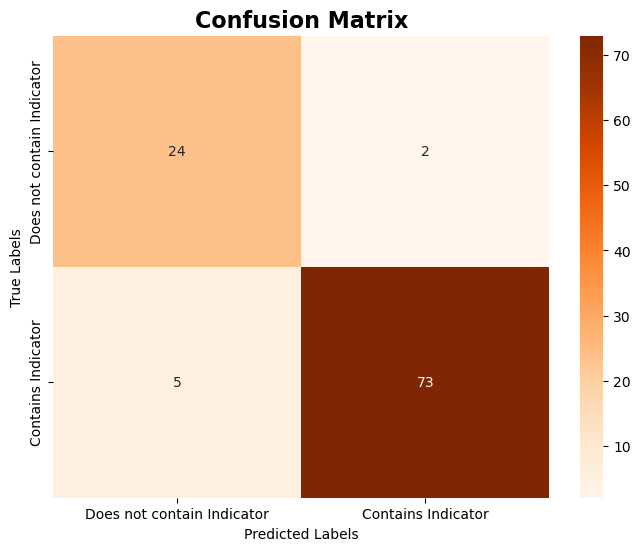

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate a heatmap plot of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_df, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')

# Change the labels of the x and y axes
plt.xticks([0.5, 1.5], ['Does not contain Indicator', 'Contains Indicator'])
plt.yticks([0.5, 1.5], ['Does not contain Indicator', 'Contains Indicator'])

plt.show()

### Example predictions:

In [47]:
unseen = pd.read_csv(file_name2)

In [67]:
muestra_df = pd.concat([unseen.frase, y_true, y_pred], axis = 1)
muestra_df.columns = ['Testimony phrase', 'Contains indicator', 'Prediction']

In [69]:
muestra_df[6:16].reset_index(drop = True)

,Testimony phrase,Contains indicator,Prediction
0,por ello nunca deje de trabajar yo siempre est...,1,1
1,y al siguiente día iba a trabajar y ese es mi ...,1,1
2,"“Hola, me llamo Marta y tengo 16 años.",0,0
3,Hace 10 años me diagnosticaron un tumor en mi ...,1,1
4,Debido al tumor estuve todo el año ingresada y...,0,0
5,"De eso ya me recuperé, rehice mi vida y volví ...",1,1
6,En diciembre del año pasado me volvió a salir ...,1,1
7,", pero esta vez los traumatólogos han podido s...",1,1
8,Actualmente estoy en tratamiento con quimio.,0,0
9,La recuperación es lenta aunque positiva,1,1
